# Тема соревнования на Kaggle: Проноз успешных стартапов

## Описание соревнования

Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle.

## Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'  

*kaggle_startups_train_01.csv* - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.  
*kaggle_startups_test_01.csv* - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Необхордимо - предсказать значение 'status' для каждого стартапа из этого датасета.  
*kaggle_startups_sample_submit_01.csv* - файл с примером предсказаний в правильном формате.  
**name** - идентификатор (название) стартапа в тестовом наборе.  
**status** - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].  

name - Название стартапа  
category_list - Список категорий, к которым относится стартап  
funding_total_usd - Общая сумма финансирования в USD  
status - Статус стартапа (закрыт или действующий)  
country_code - Код страны  
state_code - Код штата  
region - Регион  
city - Город  
funding_rounds - Количество раундов финансирования  
founded_at - Дата основания  
first_funding_at - Дата первого раунда финансирования  
last_funding_at - Дата последнего раунда финансирования  
closed_at - Дата закрытия стартапа (если применимо)  
lifetime - Время существования стартапа в днях  

## Цель исследования

Разработать модель, которая может предсказать какие стартапы закроются

## Ход исследования

Шаг 1. Загрузка и ознакомление с данными  
Шаг 2. Предварительная обработка  
Шаг 3. Полноценный разведочный анализ  
Шаг 4. Разработка новых синтетических признаков  
Шаг 5. Проверка на мультиколлинеарность  
Шаг 6. Отбор финального набора обучающих признаков  
Шаг 7. Выбор и обучение моделей  
Шаг 8. Итоговая оценка качества предсказания лучшей модели  
Шаг 9. Анализ важности ее признаков  
Шаг 10. Подготовка отчета по исследованию  

### 1. Загрузка и ознакомление с данными

In [1]:
import zipfile
import sys
import shap
# Загрузка и работа с данными
import pandas as pd  # Работа с данными в формате таблиц
import numpy as np  # Математические операции и работа с массивами
from datetime import datetime  # Работа с датами и временем

# Предварительная обработка данных
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler  # Кодирование и масштабирование признаков
from sklearn.impute import SimpleImputer  # Заполнение пропусков в данных
import category_encoders as ce  # Расширенные методы кодирования категориальных признаков

# Разведочный анализ данных и визуализация
import matplotlib.pyplot as plt  # Базовая визуализация данных
import seaborn as sns  # Расширенная визуализация данных
import plotly.express as px  # Интерактивные графики

# Разработка признаков
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif  # Отбор признаков
from sklearn.decomposition import PCA  # Снижение размерности

# Проверка на мультиколлинеарность
import statsmodels.api as sm  # Статистические модели и проверка мультиколлинеарности

# Моделирование и обучение
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score  # Разделение данных и подбор гиперпараметров
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Энсамблевые методы
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.svm import SVC  # Метод опорных векторов
import xgboost as xgb  # XGBoost модель
import lightgbm as lgb  # LightGBM модель
import catboost as cb  # CatBoost модель

# Оценка моделей
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report  # Метрики оценки моделей

# Создание пайплайнов
from sklearn.pipeline import Pipeline  # Создание пайплайнов для обработки данных и моделирования
from sklearn.compose import ColumnTransformer  # Применение разных трансформаций к разным столбцам

# Работа с файлами и системными путями
import os  # Работа с операционной системой и файловыми путями
import warnings  # Управление предупреждениями

# Для сохранения моделей
import joblib  # Сохранение и загрузка моделей

# Определение числовых и категориальных признаков
numeric_features = ['funding_total_usd', 'funding_rounds', 'lifetime']
categorical_features = ['category_list', 'country_code', 'state_code', 'region', 'city']

# Создание трансформеров для разных типов признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение трансформеров в ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Пайплайн с моделью
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [2]:
# Путь к файлу kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "D:/programs/python/Kaggle"

os.environ['KAGGLE_USERNAME'] = 'lekar17'
os.environ['KAGGLE_KEY'] = '96a588d6d3bc435a84c85881334378f8'

In [3]:
!kaggle competitions download -c startups-operations-close-predictions-m-1-41-ds --path ./data

with zipfile.ZipFile("./data/startups-operations-close-predictions-m-1-41-ds.zip", "r") as zip_ref:
    zip_ref.extractall("./data")

startups-operations-close-predictions-m-1-41-ds.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Функция для загрузки данных с проверкой
def load_data(file_path):
    if not os.path.exists(file_path):
        print(f"Файл не найден: {file_path}")
        return None
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            print(f"Файл пустой: {file_path}")
            return None
        print(f"Файл успешно загружен: {file_path}")
        return df
    except Exception as e:
        print(f"Ошибка при загрузке файла {file_path}: {e}")
        return None

# Пути к данным
train_path = "C:/Users/Lekar/data/kaggle_startups_train_28062024.csv"
test_path = "C:/Users/Lekar/data/kaggle_startups_test_28062024.csv"
sample_submit_path = "C:/Users/Lekar/data/kaggle_startups_sample_submit_28062024.csv"

# Загрузка данных в DataFrame с проверкой
train_df = load_data(train_path)
test_df = load_data(test_path)
sample_submit_df = load_data(sample_submit_path)

# Проверка, что все необходимые DataFrame загружены
if train_df is not None and test_df is not None and sample_submit_df is not None:
    print("\nВсе файлы успешно загружены.\n")
else:
    print("\nНекоторые файлы не были загружены. Проверьте пути к файлам и попробуйте снова.\n")
    sys.exit("Загрузка необходимых файлов не удалась.")

# Общая информация о тренировочном наборе данных
print("=== Общая информация о тренировочном наборе данных ===")
print(train_df.info())
print("\n")

# Описательная статистика для числовых признаков в тренировочном наборе
print("=== Описательная статистика для числовых признаков (Train) ===")
print(train_df.describe())
print("\n")

# Общая информация о тестовом наборе данных
print("=== Общая информация о тестовом наборе данных ===")
print(test_df.info())
print("\n")

# Описательная статистика для числовых признаков в тестовом наборе
print("=== Описательная статистика для числовых признаков (Test) ===")
print(test_df.describe())
print("\n")

# Проверка на пропуски в тренировочном наборе данных
print("=== Пропущенные значения в тренировочном наборе данных ===")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])
print("\n")

# Проверка на пропуски в тестовом наборе данных
print("=== Пропущенные значения в тестовом наборе данных ===")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])
print("\n")

Файл успешно загружен: C:/Users/Lekar/data/kaggle_startups_train_28062024.csv
Файл успешно загружен: C:/Users/Lekar/data/kaggle_startups_test_28062024.csv
Файл успешно загружен: C:/Users/Lekar/data/kaggle_startups_sample_submit_28062024.csv

Все файлы успешно загружены.

=== Общая информация о тренировочном наборе данных ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-nu

**Размеры наборов данных:** обучающий набор состоит из 53 000 записей и 11 признаков, тестовый — из 13 000 записей и 10 признаков.  
**Пропущенные значения:** в обоих наборах данных есть пропуски в столбцах category_list и state_code, которые необходимо обработать (например, заполнить наиболее часто встречающимися значениями или другим способом).  
**Типы признаков:** наблюдаются как числовые, так и категориальные признаки.  
**Распределение данных:** числовые признаки демонстрируют разнообразное распределение. Категориальные признаки также содержат полезную информацию, но требуют дополнительной обработки из-за наличия пропусков.  

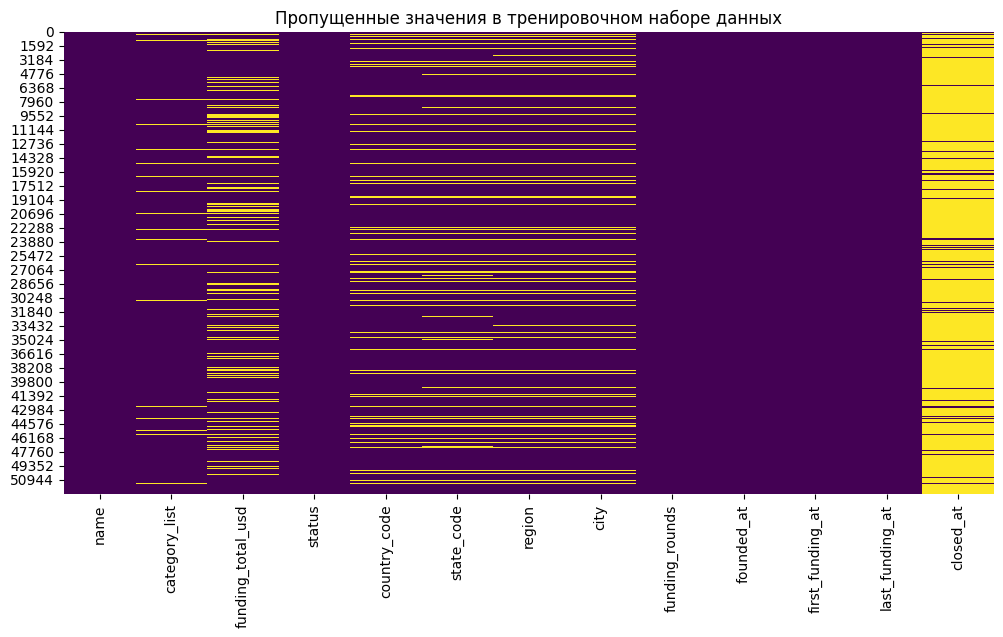

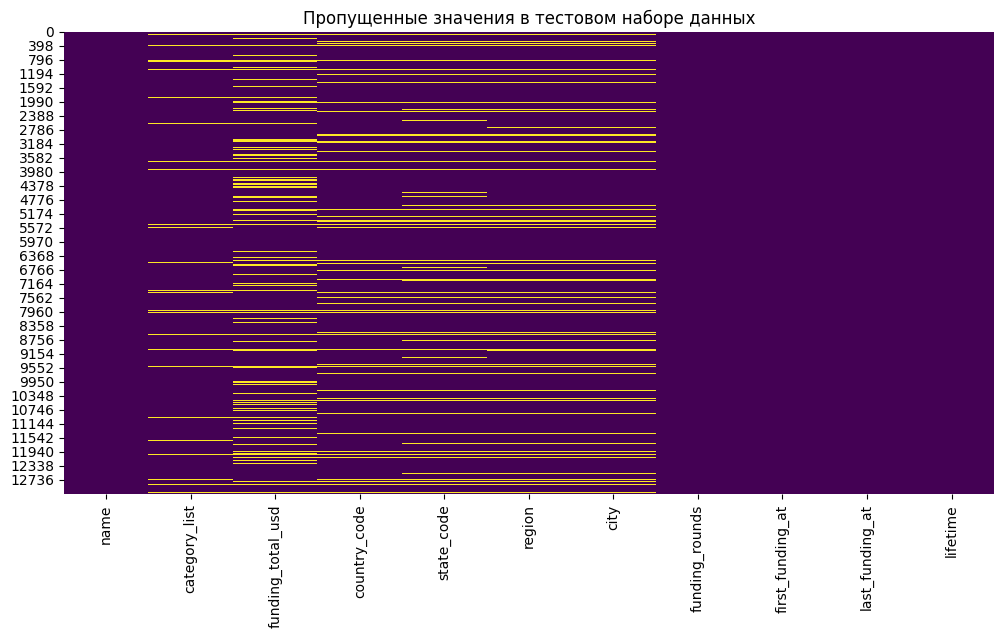

In [5]:
# Визуализация пропусков в тренировочном наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тренировочном наборе данных')
plt.show()

# Визуализация пропусков в тестовом наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тестовом наборе данных')
plt.show()

Тренировочные данные:  
Некоторые столбцы, такие как closed_at, имеют большое количество пропущенных значений (что видно по большим жёлтым областям). Это может означать, что значительная часть компаний не имеет данных о дате закрытия, возможно, потому что они ещё активны.
Другие столбцы, такие как country_code и state_code, также содержат пропуски, но в меньшем объёме, что указывает на то, что у некоторых компаний может отсутствовать полная географическая информация  
Тестовые данные:  
Аналогично, пропуски есть в столбцах, таких как category_list, funding_total_usd и географическая информация (country_code, state_code).
В целом, распределение пропусков похоже на обучающий набор данных.

### 2. Предварительная обработка

In [6]:
# Функция для вычисления 'lifetime'
def calculate_lifetime(row, cutoff_date):
    try:
        founded_at = datetime.strptime(row['founded_at'], '%Y-%m-%d')
    except:
        # Если дата основания некорректна или отсутствует, используем cutoff_date
        return (cutoff_date - datetime.strptime('1970-01-01', '%Y-%m-%d')).days
    if pd.notnull(row['closed_at']):
        try:
            closed_at = datetime.strptime(row['closed_at'], '%Y-%m-%d')
            return (closed_at - founded_at).days
        except:
            return (cutoff_date - founded_at).days
    else:
        return (cutoff_date - founded_at).days

# Дата формирования выгрузки
cutoff_date = datetime.strptime('2018-01-01', '%Y-%m-%d')

# Вычисление 'lifetime' для тренировочного набора данных
train_df['lifetime'] = train_df.apply(lambda row: calculate_lifetime(row, cutoff_date), axis=1)

# Проверка наличия столбца 'lifetime' в тестовом наборе данных
if 'lifetime' not in test_df.columns:
    print("'lifetime' отсутствует в тестовом наборе данных. Вычисляем 'lifetime' для тестового набора данных.")
    # В тестовом наборе данных 'lifetime' уже присутствует, поэтому ничего не делаем
else:
    print("'lifetime' уже присутствует в тестовом наборе данных.")

'lifetime' уже присутствует в тестовом наборе данных.


In [7]:
# Обработка пропусков в тренировочном наборе данных, так же ввиду новых данных необходимо обновить пайплайны

# Для числовых признаков заполняем медианой
numeric_imputer = SimpleImputer(strategy='median')
train_df[numeric_features] = numeric_imputer.fit_transform(train_df[numeric_features])
test_df[numeric_features] = numeric_imputer.transform(test_df[numeric_features])

# Для категориальных признаков заполняем 'Unknown'
categorical_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_df[categorical_features] = categorical_imputer.fit_transform(train_df[categorical_features])
test_df[categorical_features] = categorical_imputer.transform(test_df[categorical_features])

# Дополнительная обработка 'closed_at' в тренировочном наборе данных
# Если 'closed_at' пропущен, стартап все еще работает, что уже учтено при вычислении 'lifetime'

# Обновление трансформеров для категориальных признаков с учетом заполнения 'Unknown'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Обновление ColumnTransformer с новым категориальным трансформером
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Обновление пайплайна модели с новым preprocessor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

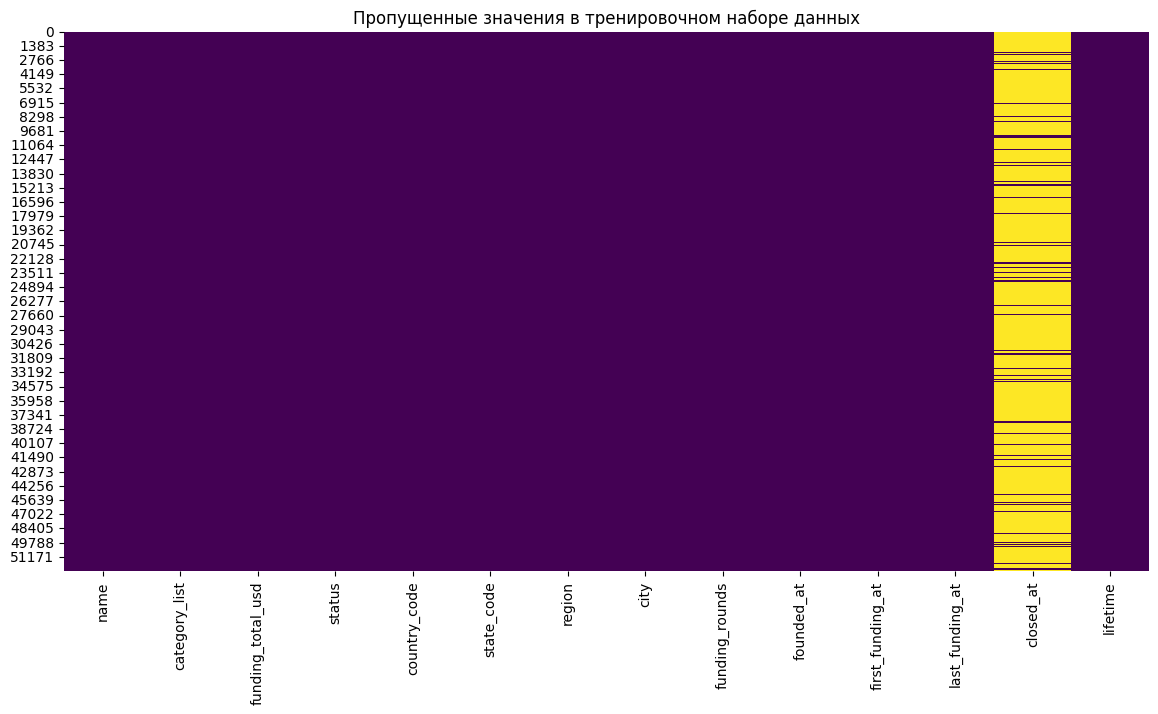

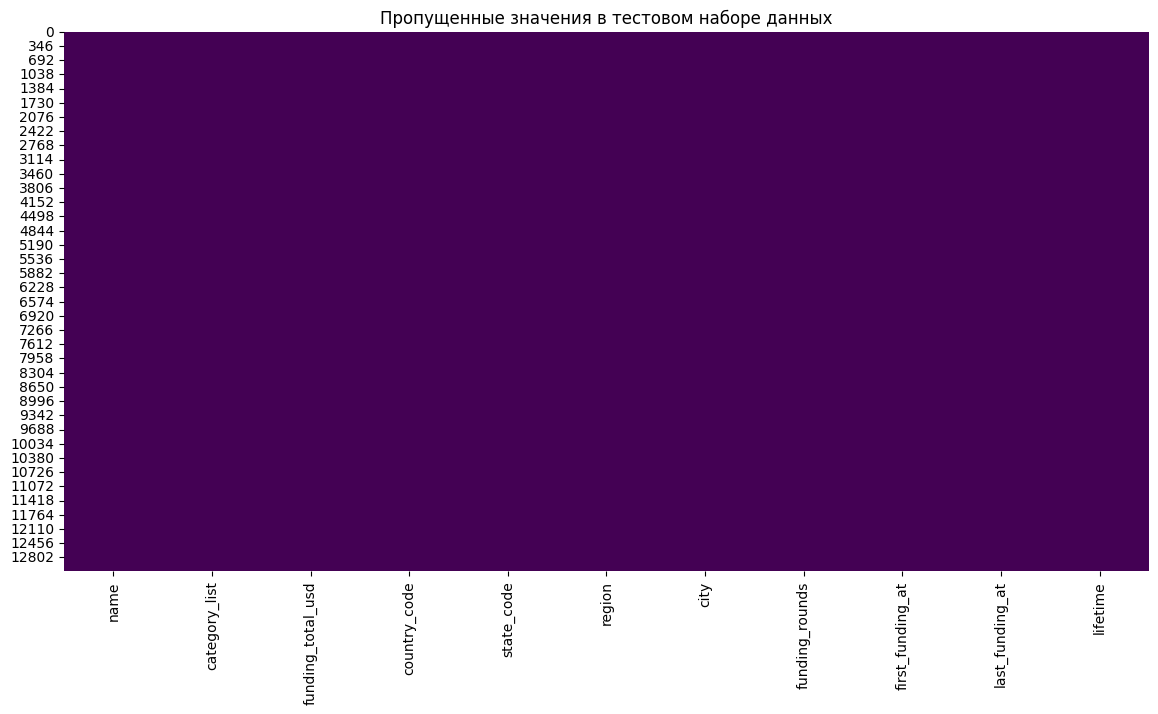

In [8]:
# Визуализация пропусков в тренировочном наборе данных
plt.figure(figsize=(14, 7))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тренировочном наборе данных')
plt.show()

# Визуализация пропусков в тестовом наборе данных
plt.figure(figsize=(14, 7))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тестовом наборе данных')
plt.show()

В связи с тем, что природа пропусков до конца не была выяснена и скорее всего основная причина пропусков это утечка данных, было принято решение в категориальных данных, чтобы не терять информацию заполнить пропуски значениями 'Unknown', числовые признаки заполнены медианным значением, как наиболее близким значением и не смещающим выборку

In [9]:
def process_duplicates(df):
    # Расчет процента явных дубликатов
    explicit_duplicates = df.duplicated().sum()
    explicit_percentage = (explicit_duplicates / len(df)) * 100
    print(f"Процент явных дубликатов: {explicit_percentage:.2f}%")
    
    # Удаление явных дубликатов
    df = df.drop_duplicates()
    
    # Размер DataFrame после удаления явных дубликатов
    print(f"Размер DataFrame после удаления явных дубликатов: {df.shape}")
    
    # Поиск неявных дубликатов на основе столбца 'name'
    implicit_duplicates = df.duplicated(subset=['name']).sum()
    implicit_percentage = (implicit_duplicates / len(df)) * 100
    print(f"Процент неявных дубликатов на основе 'name': {implicit_percentage:.2f}%")
    
    # Удаление неявных дубликатов
    df = df.drop_duplicates(subset=['name'])
    
    # Финальный размер DataFrame
    print(f"Размер DataFrame после удаления неявных дубликатов: {df.shape}")
    
    return df

# Применение функции к тренировочному набору данных
train_df = process_duplicates(train_df)

# Применение функции к тестовому набору данных
test_df = process_duplicates(test_df)

Процент явных дубликатов: 0.00%
Размер DataFrame после удаления явных дубликатов: (52516, 14)
Процент неявных дубликатов на основе 'name': 0.00%
Размер DataFrame после удаления неявных дубликатов: (52516, 14)
Процент явных дубликатов: 0.00%
Размер DataFrame после удаления явных дубликатов: (13125, 11)
Процент неявных дубликатов на основе 'name': 0.00%
Размер DataFrame после удаления неявных дубликатов: (13125, 11)


В данном датасете столбец 'name' служит идентификатором (названием) стартапа. Предполагается, что каждое название уникально для одного стартапа. Поэтому, если в данных присутствуют несколько записей с одинаковым 'name', это, вероятно, указывает на дубликаты одной и той же компании  

Другие столбцы, такие как 'category_list', 'country_code', 'state_code' и т.д., могут содержать схожие или одинаковые значения для разных стартапов. Например, множество стартапов могут принадлежать к одной категории или находиться в одном регионе. Проверка на дубликаты по этим столбцам не позволит эффективно выявить повторяющиеся записи одной и той же компании.

### 3. Полноценный разведочный анализ

In [10]:
def exploratory_analysis(train_df, test_df):
    sns.set(style="whitegrid")
    plt.rcParams["figure.figsize"] = (14, 7)

    # Объединение train и test для единообразной обработки
    train_combined = train_df.copy()
    test_combined = test_df.copy()
    train_combined['dataset'] = 'train'
    test_combined['dataset'] = 'test'
    combined_df = pd.concat([train_combined, test_combined], ignore_index=True)

    # Преобразование строковых дат в datetime
    date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
    for col in date_columns:
        combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')

    # Вычисление 'lifetime' уже выполнено, проверим его наличие
    if 'lifetime' not in combined_df.columns:
        # Если 'lifetime' отсутствует, вычислим его
        cutoff_date = datetime.strptime('2018-01-01', '%Y-%m-%d')
        def calculate_lifetime(row, cutoff_date):
            try:
                founded_at = row['founded_at']
                if pd.isnull(founded_at):
                    founded_at = datetime.strptime('1970-01-01', '%Y-%m-%d')
            except:
                founded_at = datetime.strptime('1970-01-01', '%Y-%m-%d')
            if pd.notnull(row['closed_at']):
                closed_at = row['closed_at']
                return (closed_at - founded_at).days
            else:
                return (cutoff_date - founded_at).days

        combined_df['lifetime'] = combined_df.apply(lambda row: calculate_lifetime(row, cutoff_date), axis=1)

    # Извлечение дополнительных признаков из дат
    combined_df['founded_year'] = combined_df['founded_at'].dt.year
    combined_df['founded_month'] = combined_df['founded_at'].dt.month
    combined_df['first_funding_year'] = combined_df['first_funding_at'].dt.year
    combined_df['last_funding_year'] = combined_df['last_funding_at'].dt.year
    combined_df['closed_year'] = combined_df['closed_at'].dt.year

    # Определение числовых и категориальных признаков
    numeric_features = ['funding_total_usd', 'funding_rounds', 'lifetime',
                        'founded_year', 'founded_month', 'first_funding_year',
                        'last_funding_year', 'closed_year']
    categorical_features = ['category_list', 'country_code', 'state_code', 'region', 'city']

    # Разделение обратно на train и test
    train_combined = combined_df[combined_df['dataset'] == 'train'].drop('dataset', axis=1)
    test_combined = combined_df[combined_df['dataset'] == 'test'].drop('dataset', axis=1)

    # 1. Визуализация числовых признаков
    for feature in numeric_features:
        plt.figure(figsize=(14,6))
        sns.histplot(data=train_combined, x=feature, bins=50, kde=True, color='blue', label='Train', stat="density", alpha=0.5)
        sns.histplot(data=test_combined, x=feature, bins=50, kde=True, color='orange', label='Test', stat="density", alpha=0.5)
        plt.title(f'Распределение {feature}')
        plt.legend()
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.show()

        plt.figure(figsize=(14,6))
        sns.boxplot(x='status', y=feature, data=train_combined)
        plt.title(f'{feature} по статусу стартапа')
        plt.xlabel('Status')
        plt.ylabel(feature)
        plt.show()

        plt.figure(figsize=(14,6))
        sns.kdeplot(data=train_combined, x=feature, hue='status', fill=True)
        plt.title(f'Распределение {feature} по статусу')
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.show()

    # 2. Визуализация категориальных признаков
    top_n = 20  # Количество топ категорий для отображения
    for feature in categorical_features:
        # Визуализация распределения категорий (Объединённый набор данных)
        plt.figure(figsize=(14,6))
        if train_combined[feature].nunique() > top_n:
            top_categories = train_combined[feature].value_counts().nlargest(top_n).index
            combined_df['temp_category'] = combined_df[feature].apply(lambda x: x if x in top_categories else 'Other')
            order = list(train_combined[feature].value_counts().nlargest(top_n).index) + ['Other']
            sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')
        else:
            sns.countplot(y=feature, data=combined_df, order=combined_df[feature].value_counts().index, palette='viridis')
        plt.title(f'Распределение {feature}')
        plt.xlabel('Количество')
        plt.ylabel(feature)
        plt.show()

        # Визуализация распределения категорий по статусу (Только обучающий набор)
        plt.figure(figsize=(14,6))
        if train_combined[feature].nunique() > top_n:
            top_categories = train_combined[feature].value_counts().nlargest(top_n).index
            train_combined['temp_category'] = train_combined[feature].apply(lambda x: x if x in top_categories else 'Other')
            order = list(train_combined[feature].value_counts().nlargest(top_n).index) + ['Other']
            sns.countplot(y='temp_category', hue='status', data=train_combined, order=order, palette='viridis')
        else:
            sns.countplot(y=feature, hue='status', data=train_combined, order=train_combined[feature].value_counts().index, palette='viridis')
        plt.title(f'Распределение {feature} по статусу')
        plt.xlabel('Количество')
        plt.ylabel(feature)
        plt.legend(title='Status')
        plt.show()

        # Удаление временного столбца
        if 'temp_category' in combined_df.columns:
            combined_df.drop('temp_category', axis=1, inplace=True)
        if 'temp_category' in train_combined.columns:
            train_combined.drop('temp_category', axis=1, inplace=True)

    # 3. Корреляционный анализ
    plt.figure(figsize=(16,12))
    corr = train_combined[numeric_features].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Корреляционная матрица числовых признаков')
    plt.show()

    # 4. Взаимосвязь признаков и целевого признака
    for feature in numeric_features:
        plt.figure(figsize=(14,6))
        sns.boxplot(x='status', y=feature, data=train_combined)
        plt.title(f'{feature} по статусу стартапа')
        plt.xlabel('Status')
        plt.ylabel(feature)
        plt.show()

    for feature in categorical_features:
        plt.figure(figsize=(14,6))
        if train_combined[feature].nunique() > top_n:
            top_categories = train_combined[feature].value_counts().nlargest(top_n).index
            train_combined['temp_category'] = train_combined[feature].apply(lambda x: x if x in top_categories else 'Other')
            order = list(train_combined[feature].value_counts().nlargest(top_n).index) + ['Other']
            sns.countplot(y='temp_category', hue='status', data=train_combined, order=order, palette='viridis')
        else:
            sns.countplot(y=feature, hue='status', data=train_combined, order=train_combined[feature].value_counts().index, palette='viridis')
        plt.title(f'Распределение {feature} по статусу')
        plt.xlabel('Количество')
        plt.ylabel(feature)
        plt.legend(title='Status')
        plt.show()

        # Удаление временного столбца
        if 'temp_category' in train_combined.columns:
            train_combined.drop('temp_category', axis=1, inplace=True)

    # 5. Дополнительные визуализации
    # Время существования стартапа
    plt.figure(figsize=(14,6))
    sns.histplot(data=train_combined, x='lifetime', bins=50, kde=True, hue='status', multiple='stack', palette='viridis')
    plt.title('Распределение времени существования стартапа по статусу')
    plt.xlabel('Lifetime (дни)')
    plt.ylabel('Количество')
    plt.show()

    # Количество раундов финансирования
    plt.figure(figsize=(14,6))
    sns.countplot(x='funding_rounds', data=train_combined, hue='status', palette='viridis')
    plt.title('Количество раундов финансирования по статусу')
    plt.xlabel('Количество раундов финансирования')
    plt.ylabel('Количество')
    plt.legend(title='Status')
    plt.show()

    # Общая сумма финансирования vs Время существования
    plt.figure(figsize=(14,6))
    sns.scatterplot(data=train_combined, x='funding_total_usd', y='lifetime', hue='status', alpha=0.5, palette='viridis')
    plt.title('Сумма финансирования vs Время существования по статусу')
    plt.xlabel('Funding Total (USD)')
    plt.ylabel('Lifetime (дни)')
    plt.xscale('log')  # Логарифмическая шкала из-за высоких значений
    plt.legend(title='Status')
    plt.show()

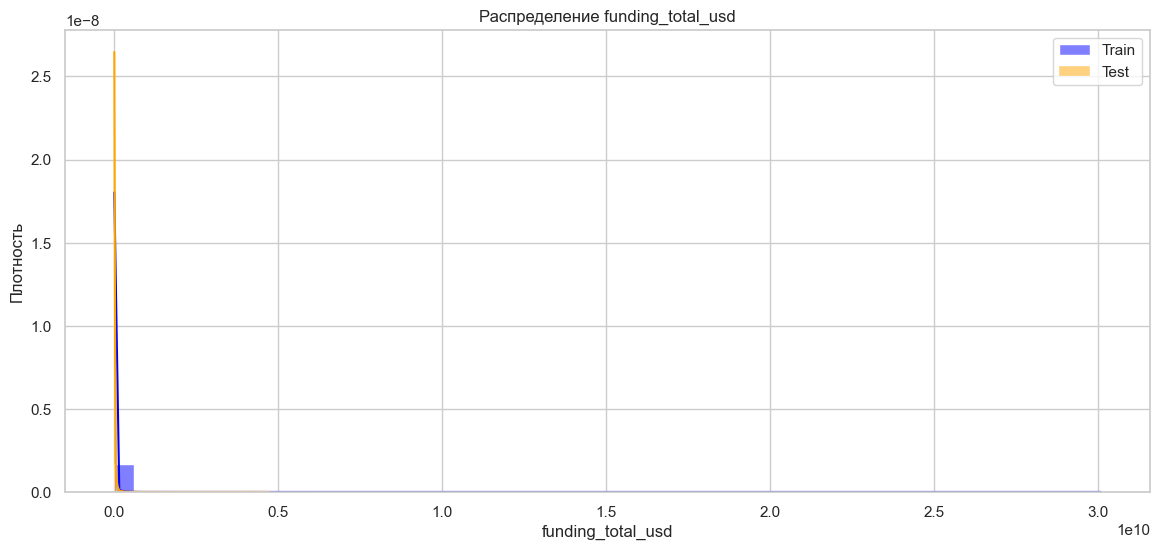

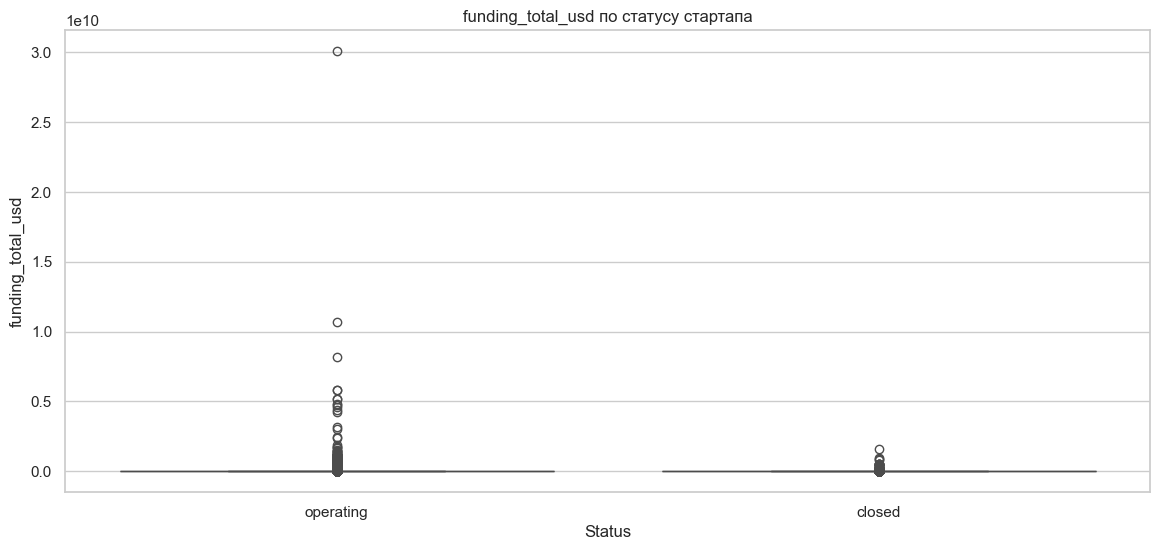

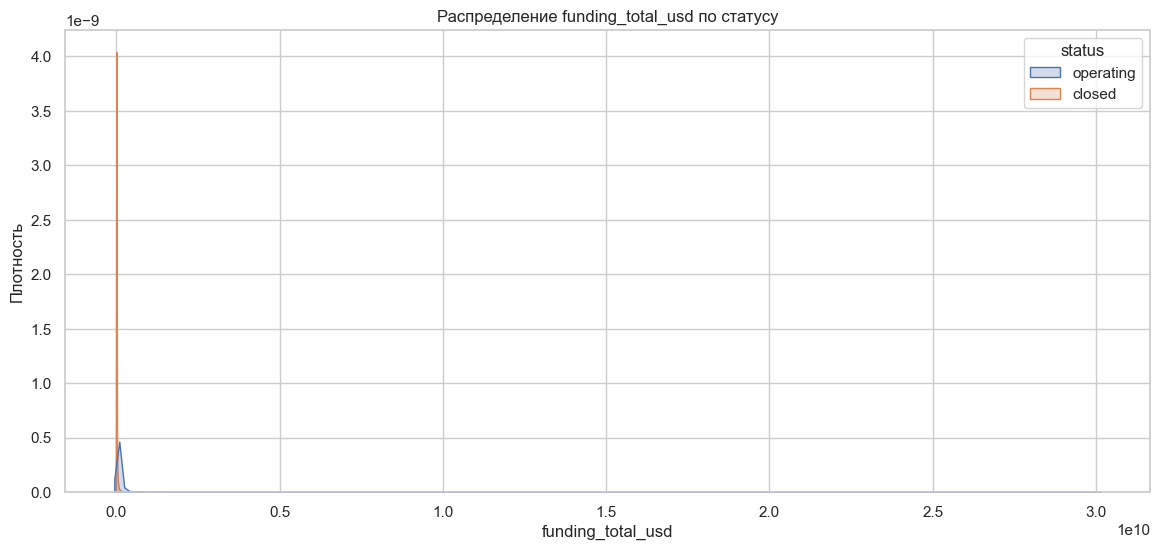

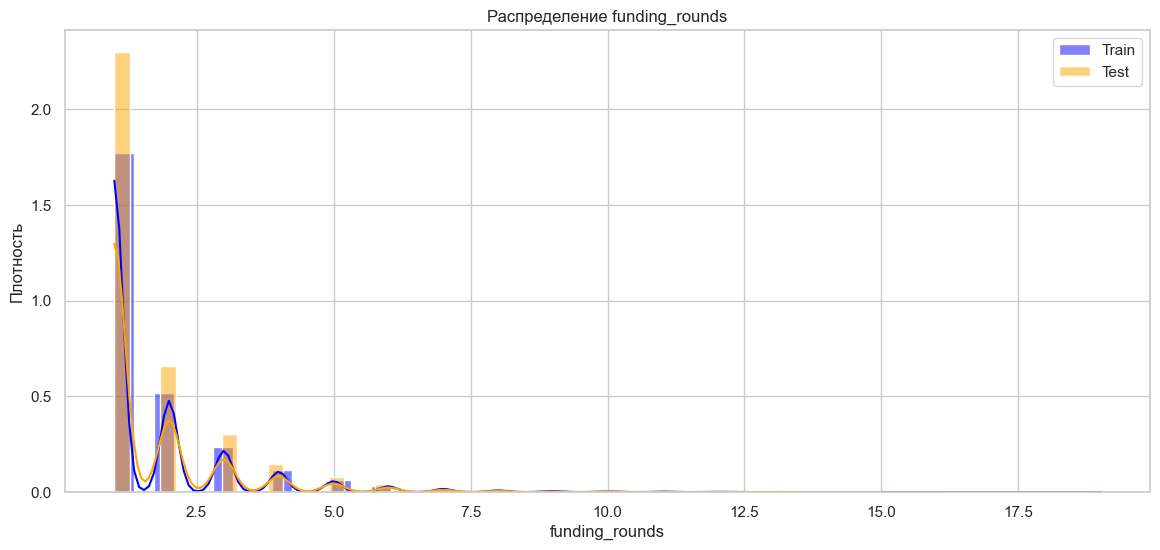

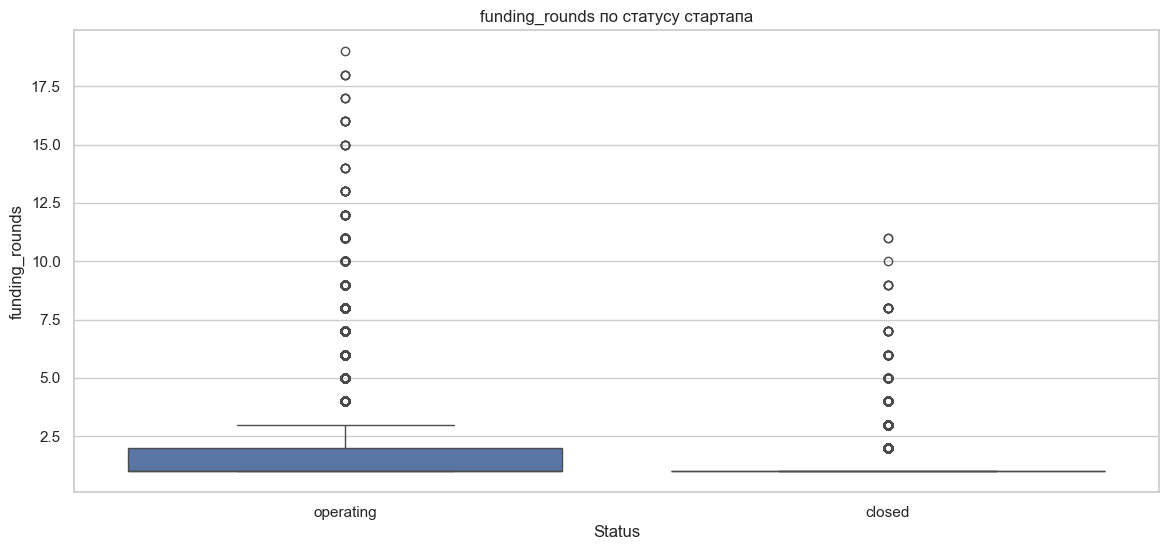

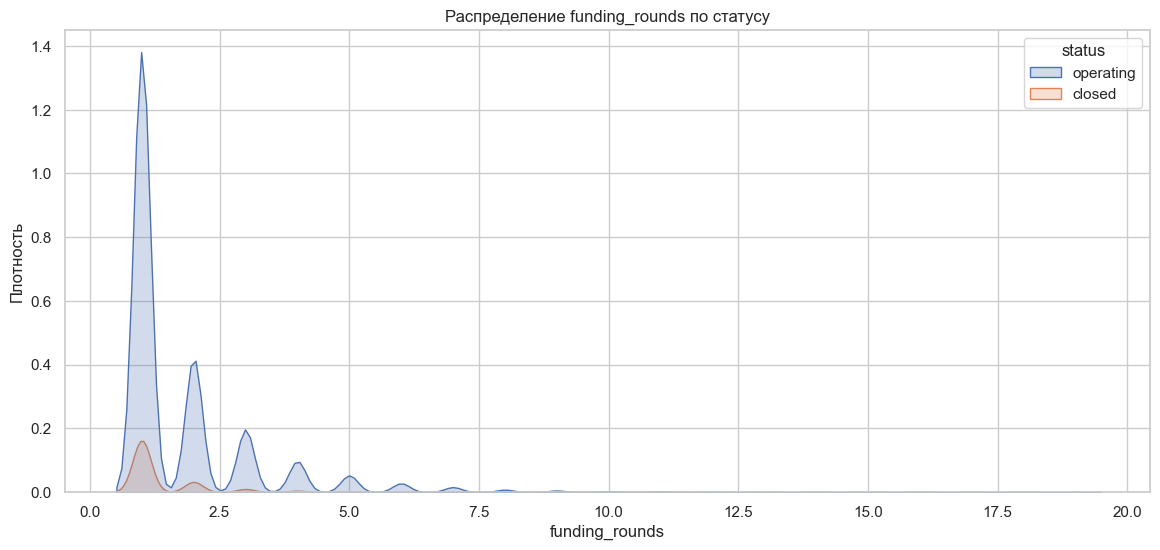

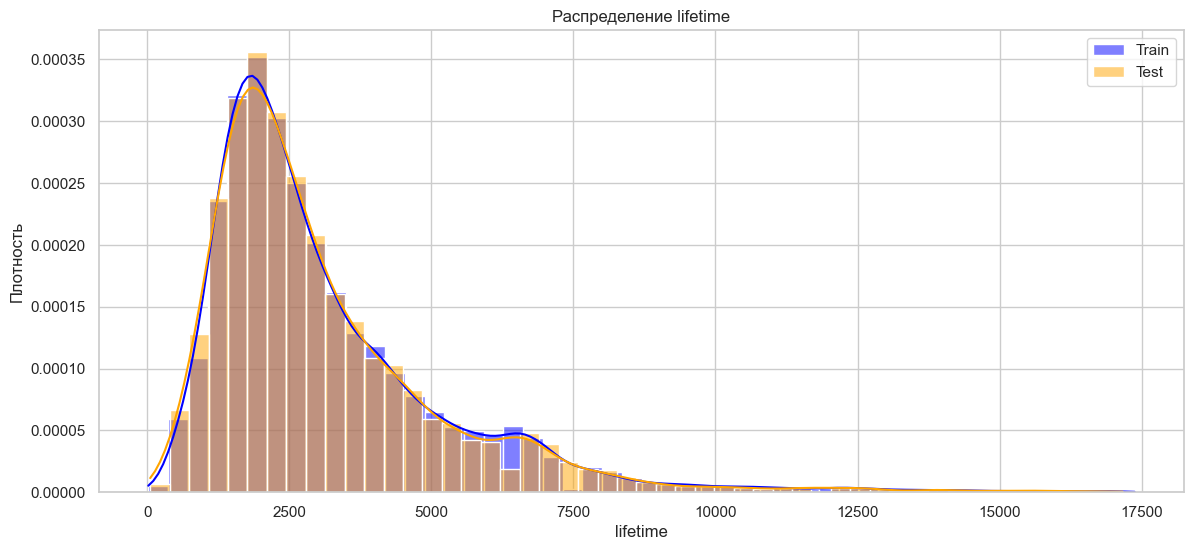

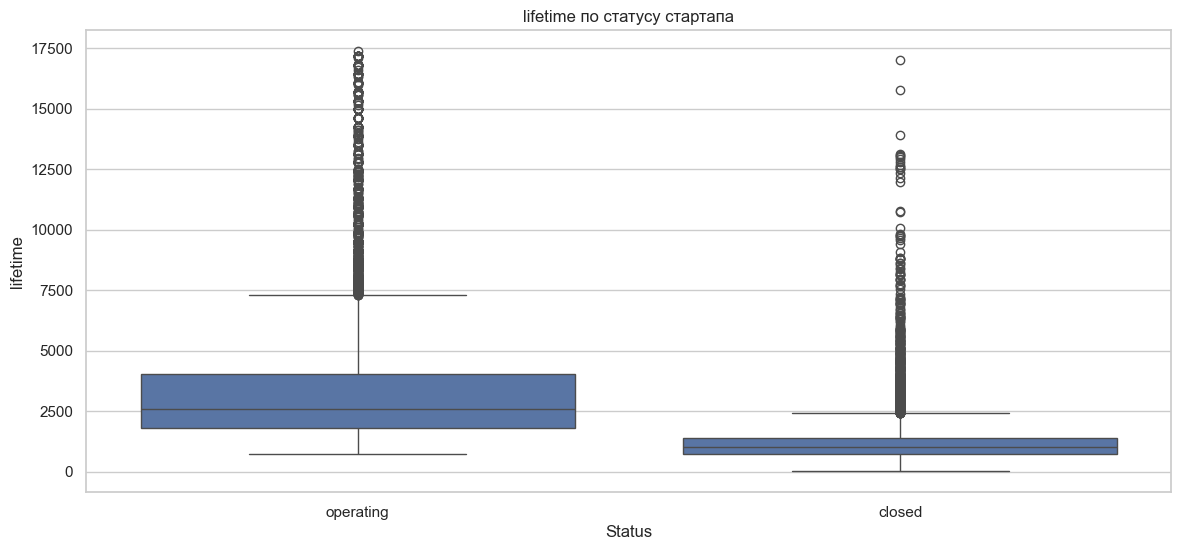

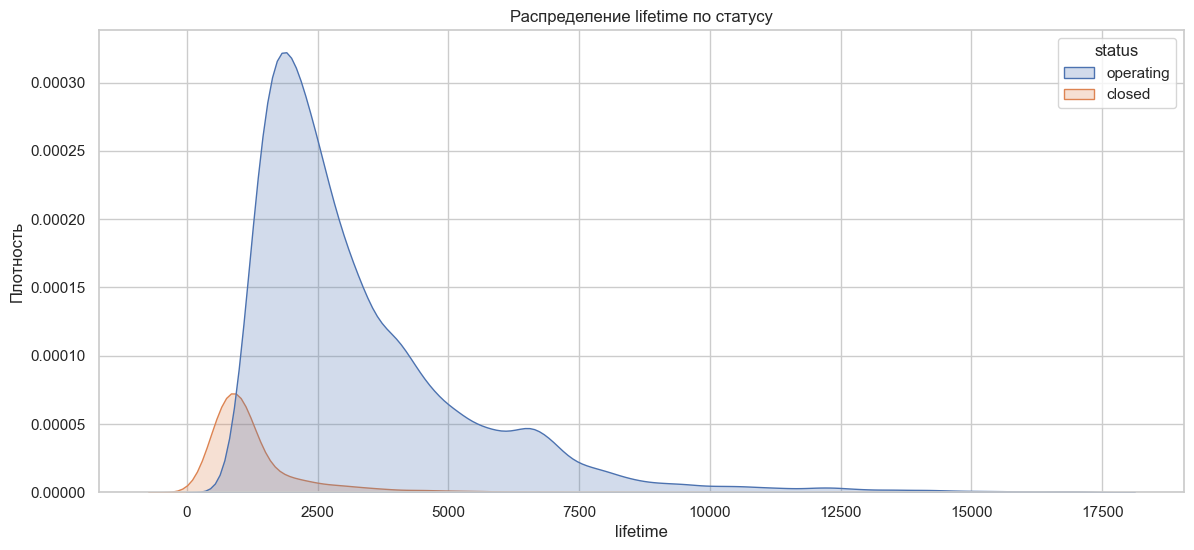

D:\programs\python\anakonda\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


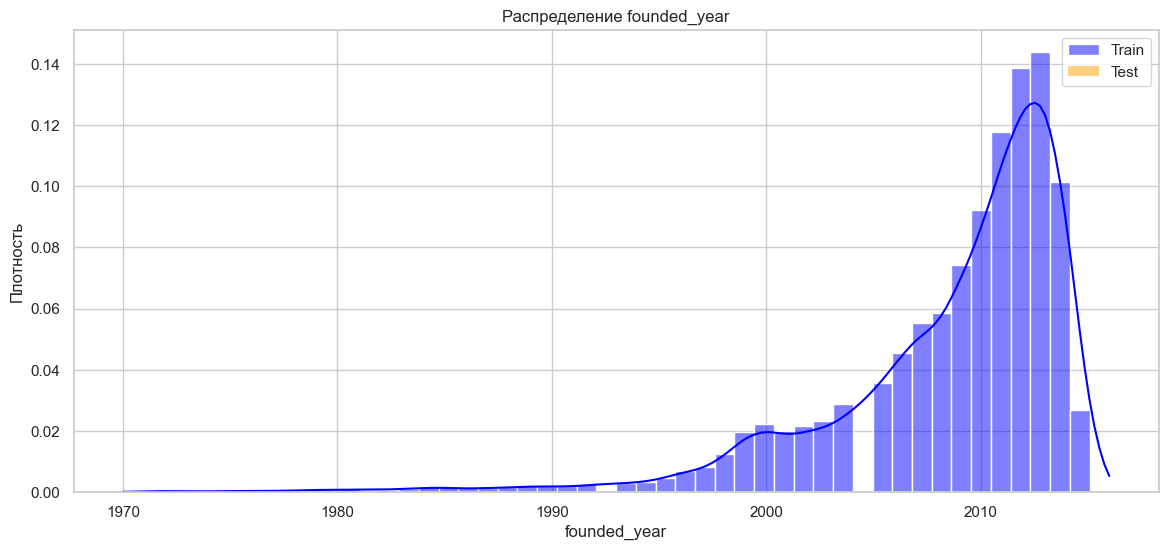

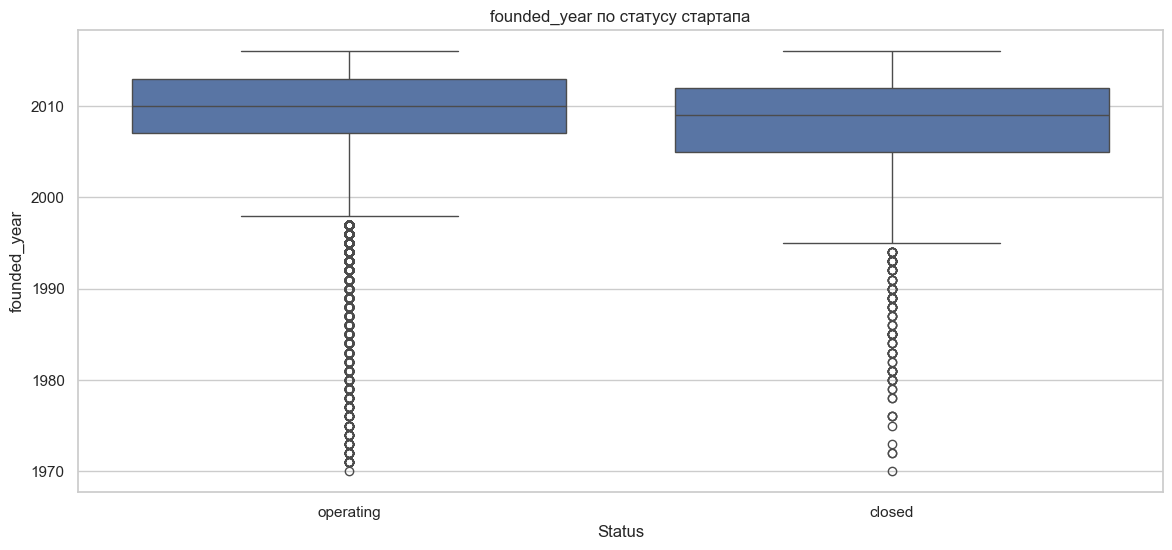

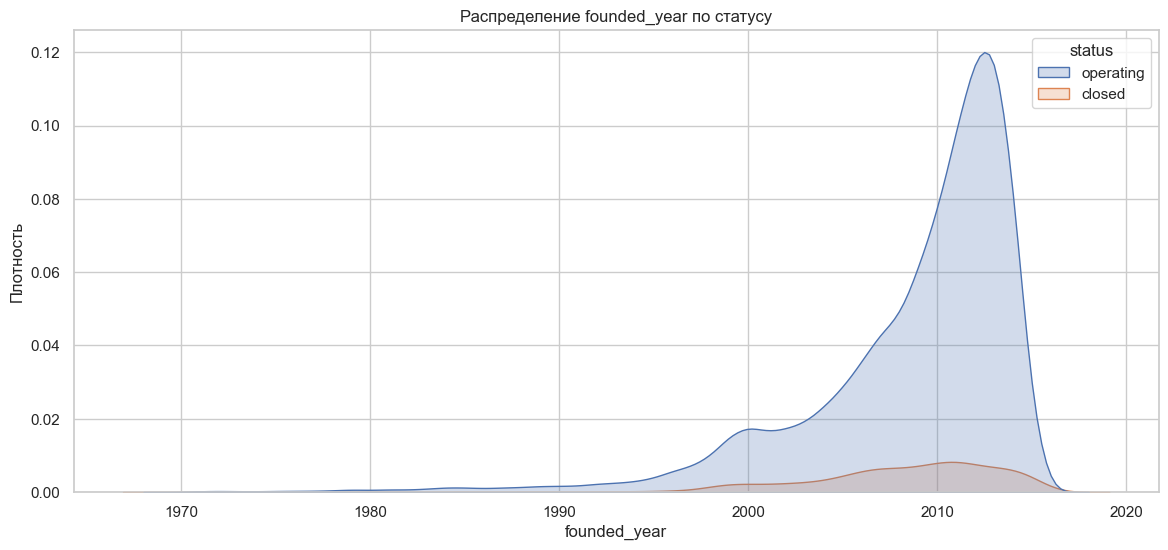

D:\programs\python\anakonda\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


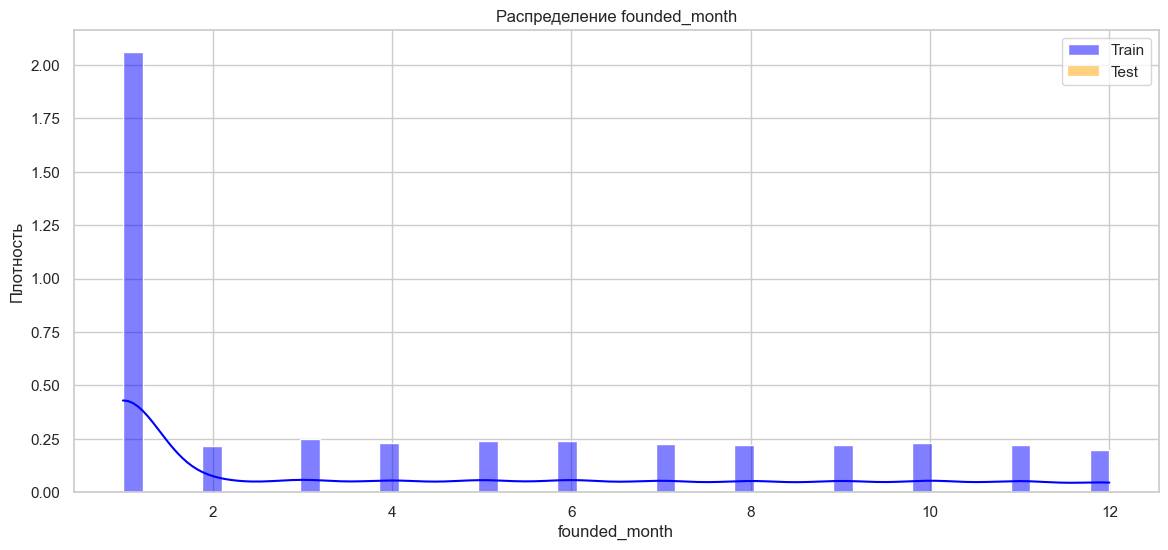

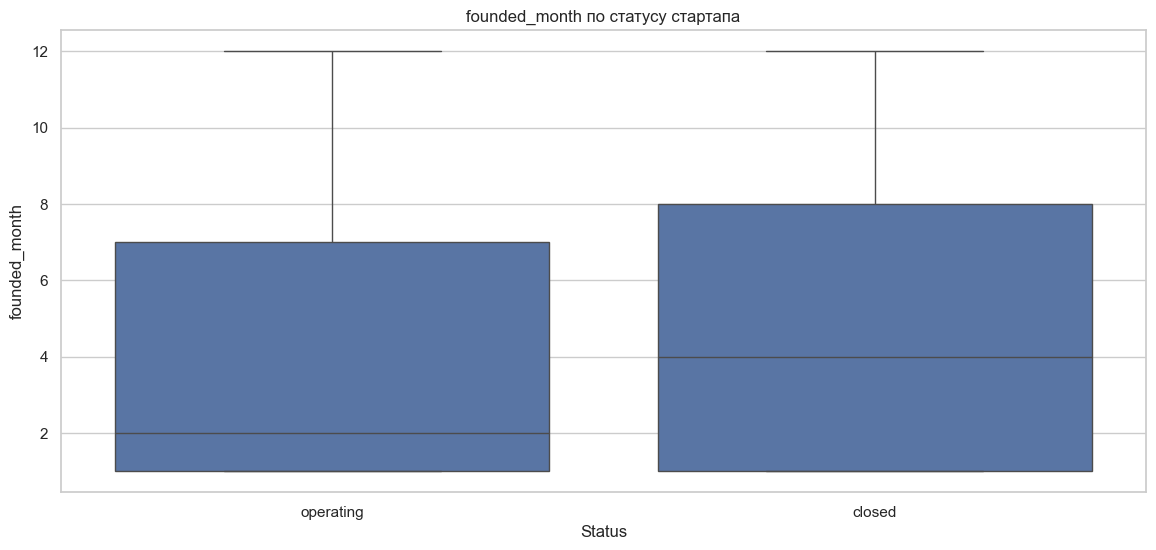

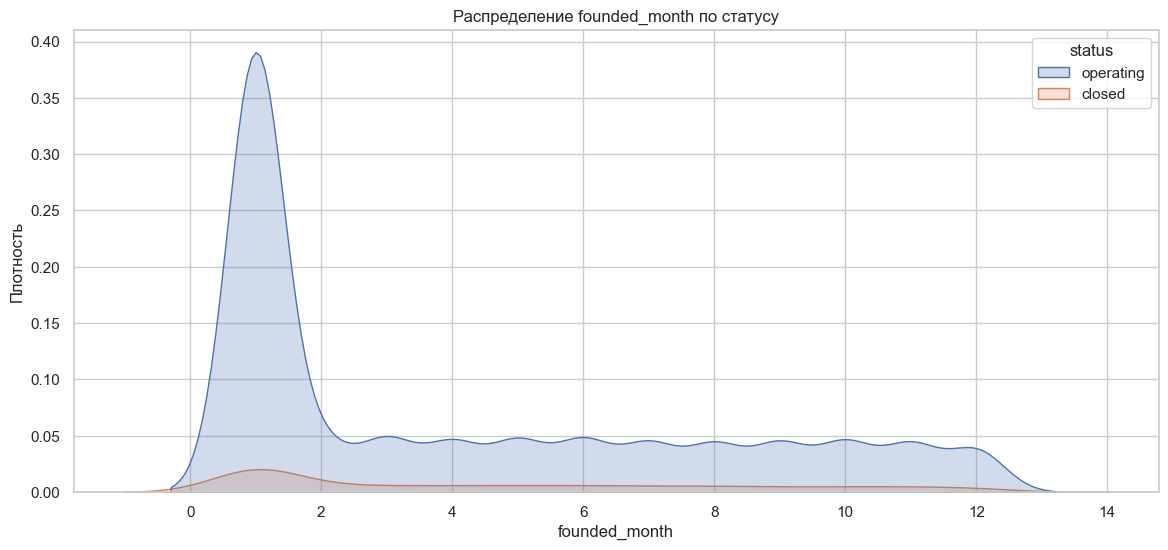

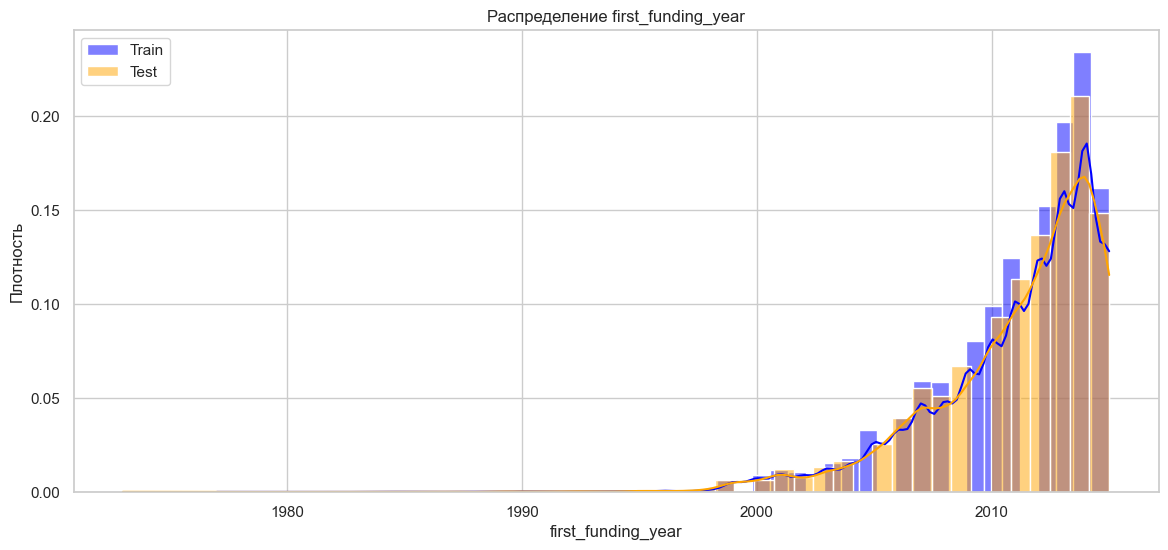

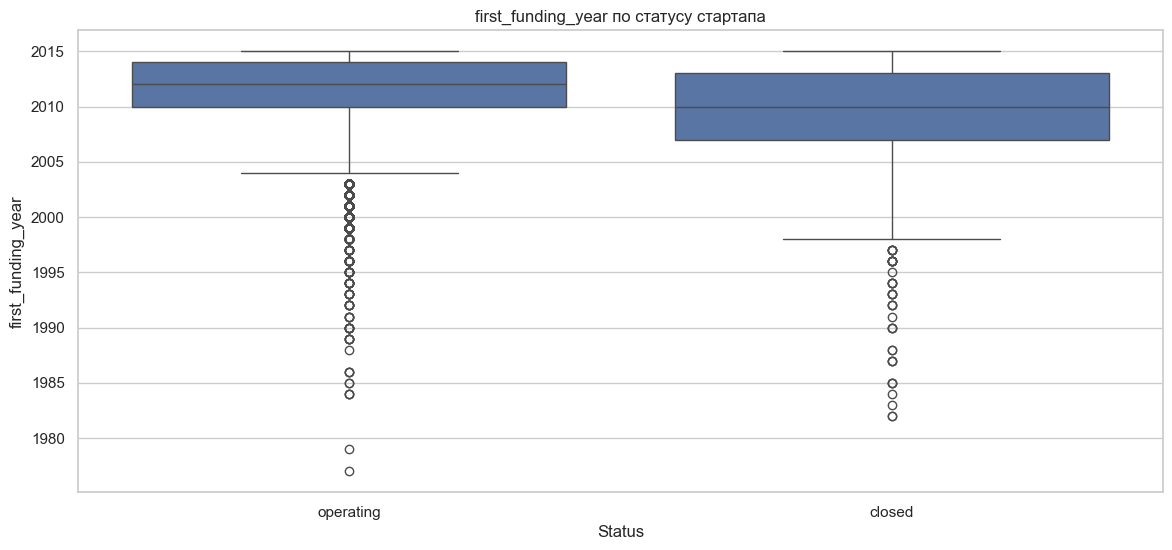

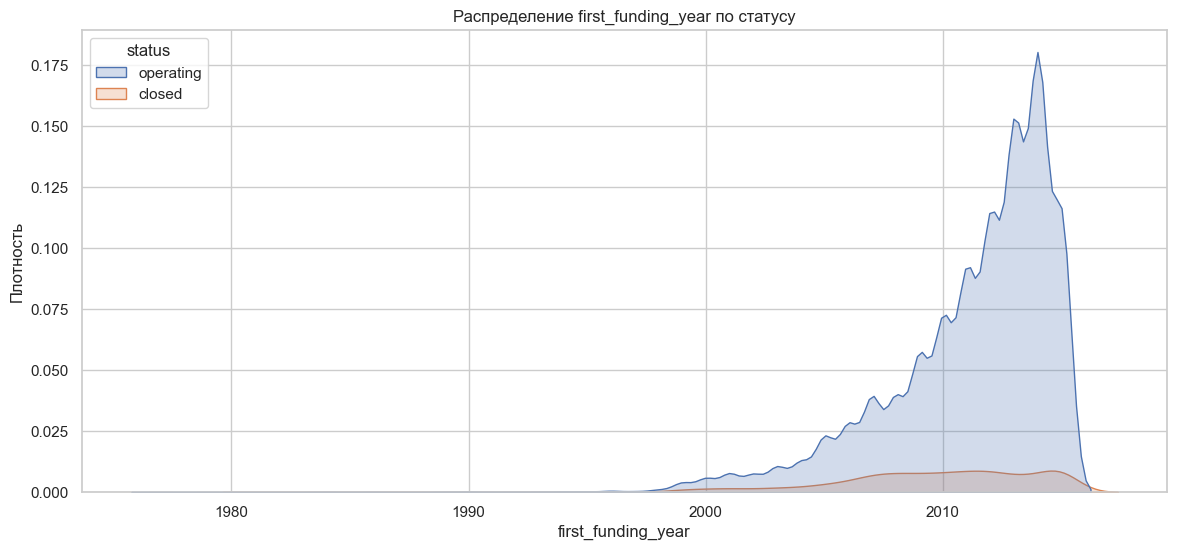

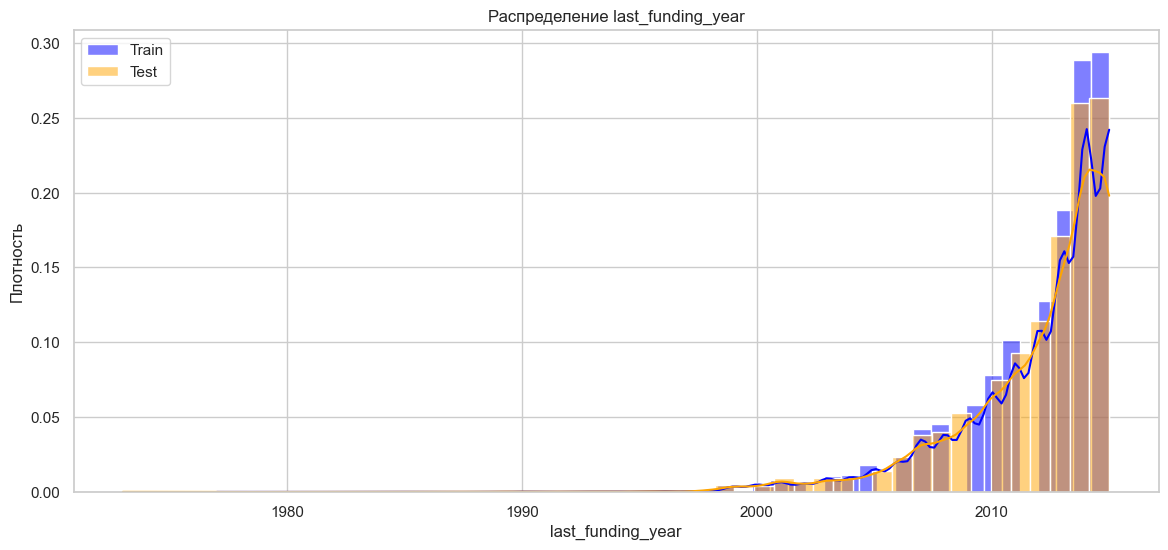

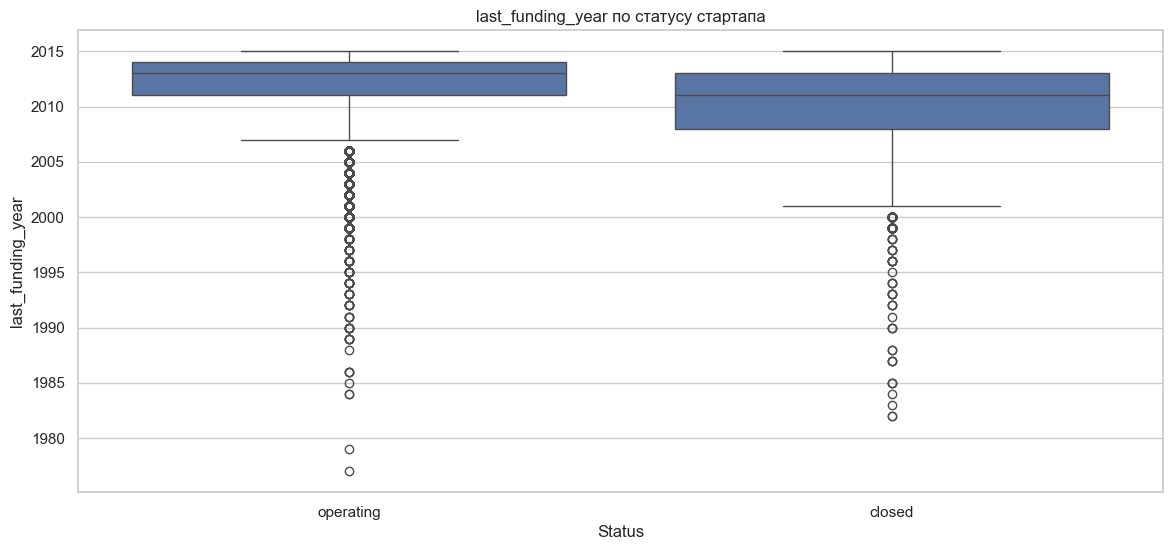

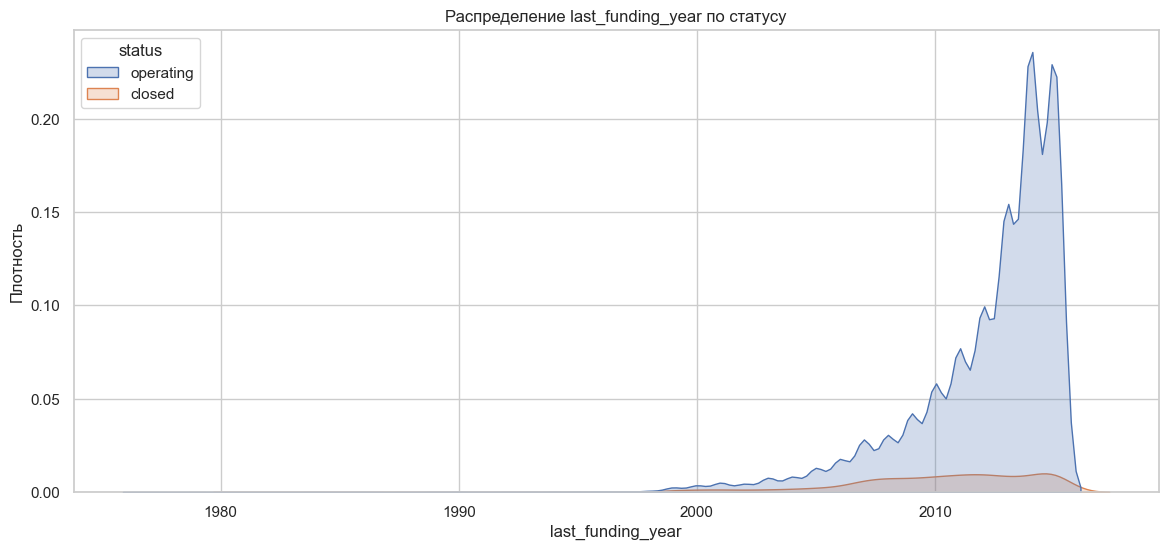

D:\programs\python\anakonda\Lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


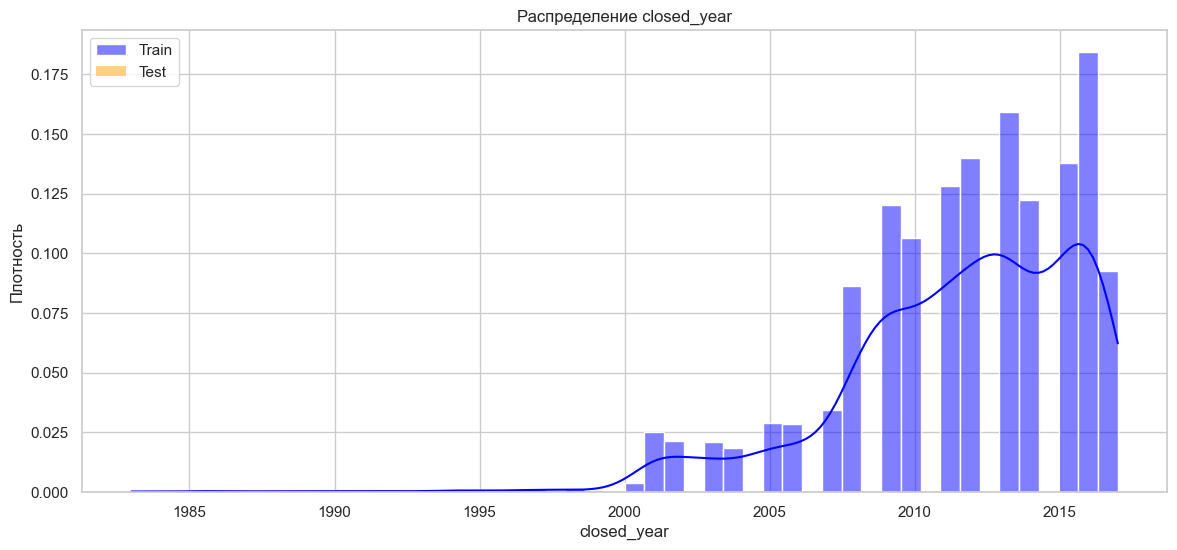

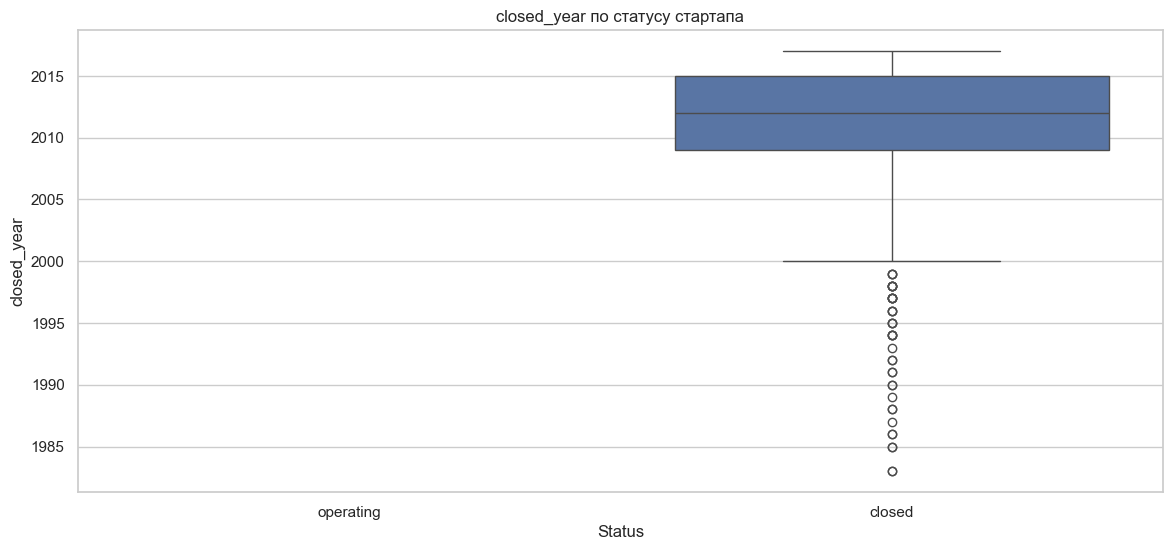

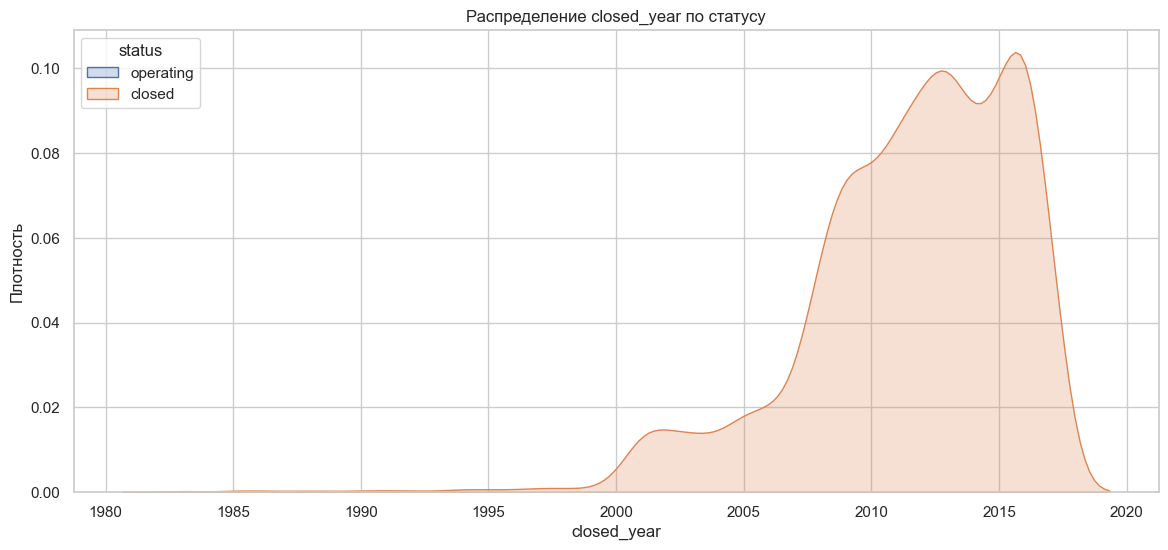

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3067016839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')


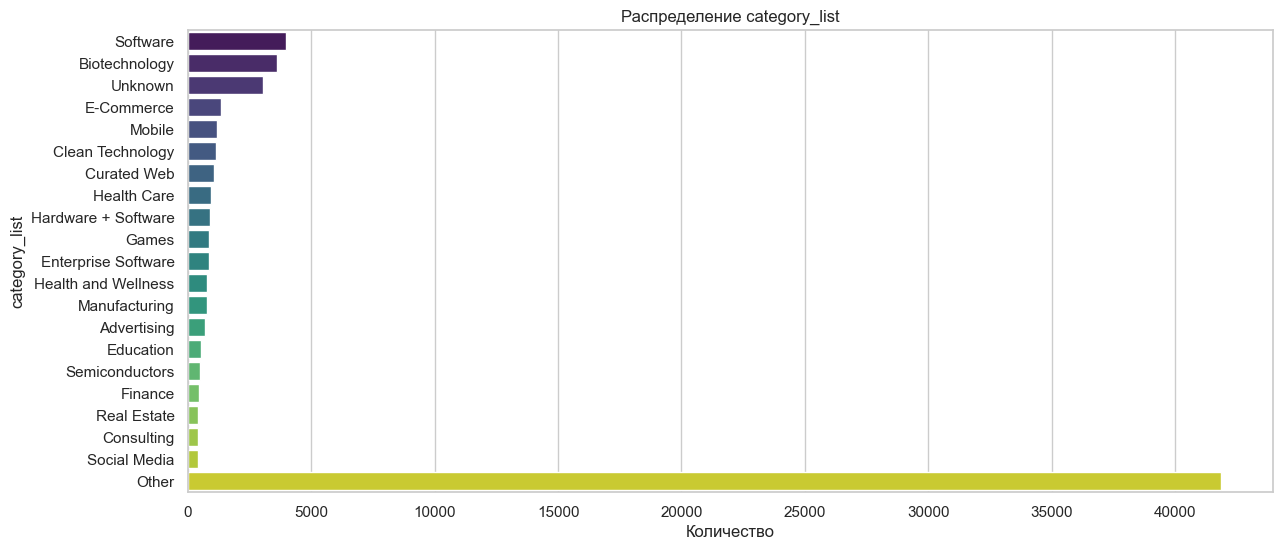

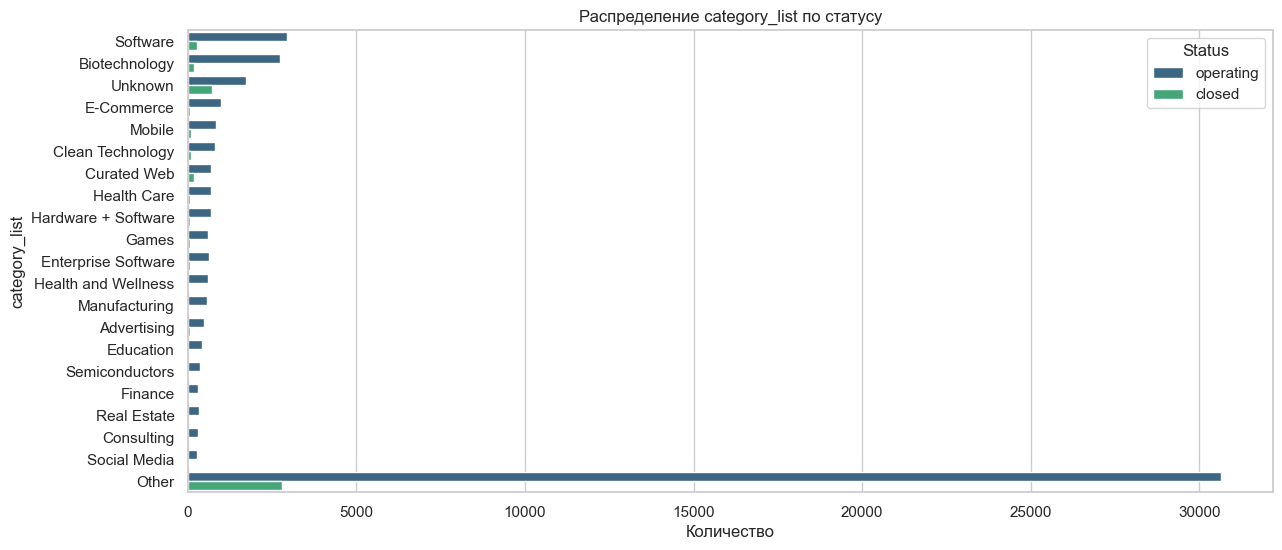

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3067016839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')


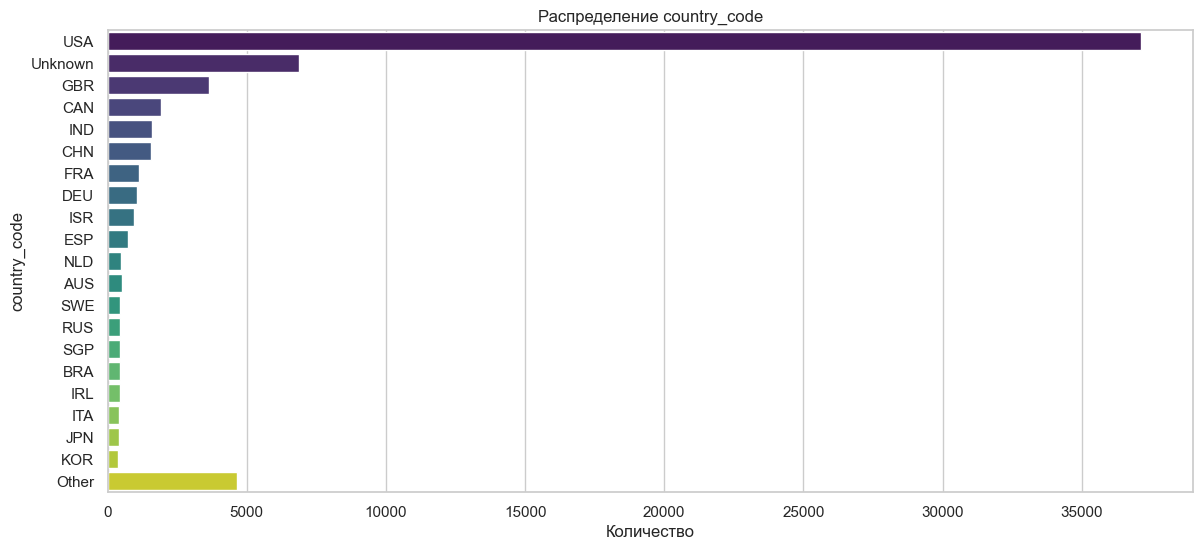

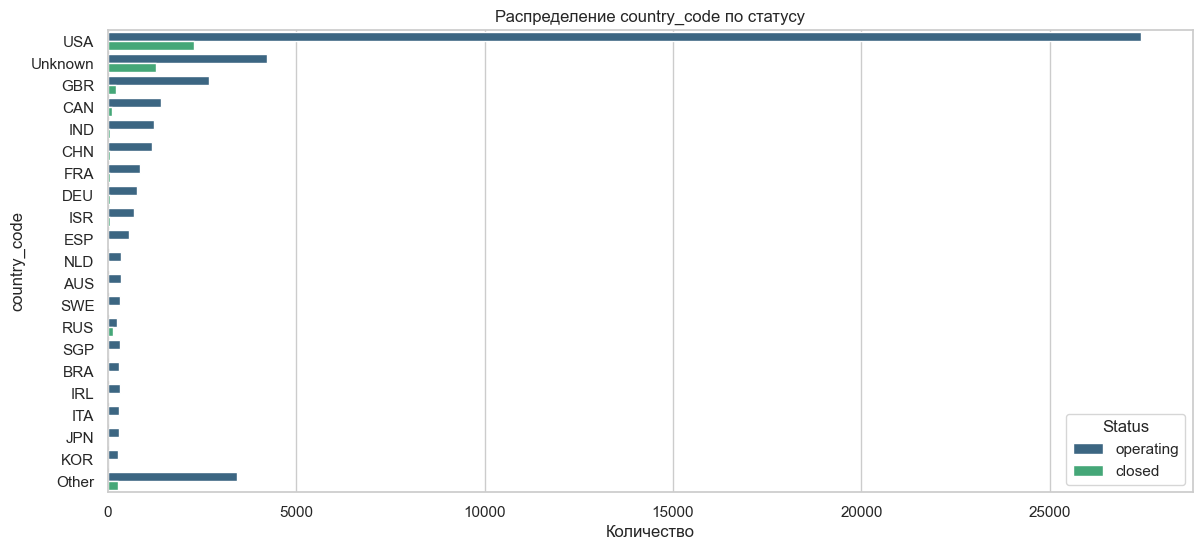

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3067016839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')


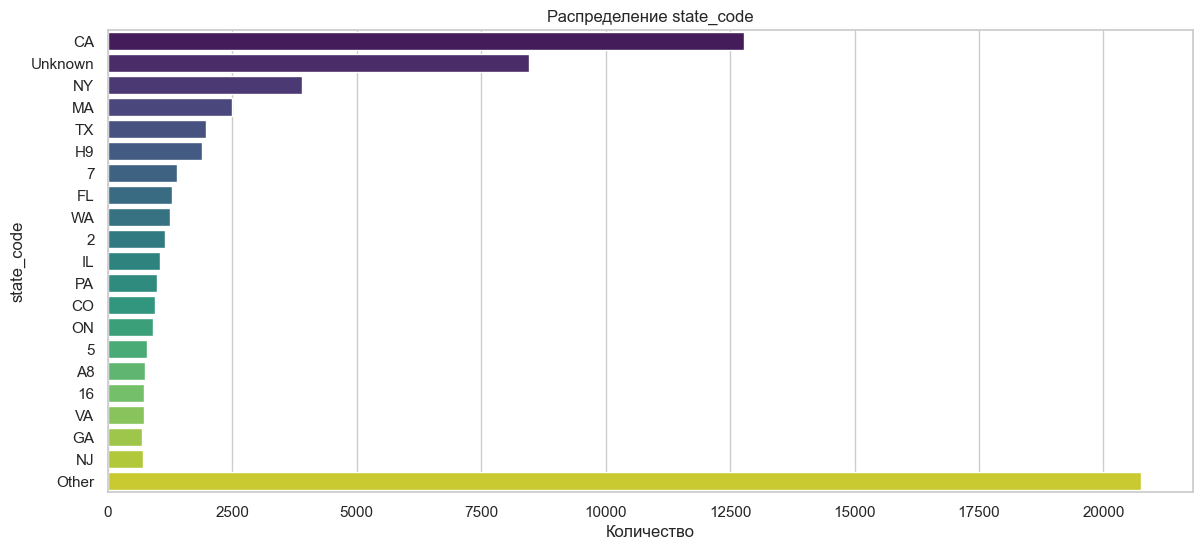

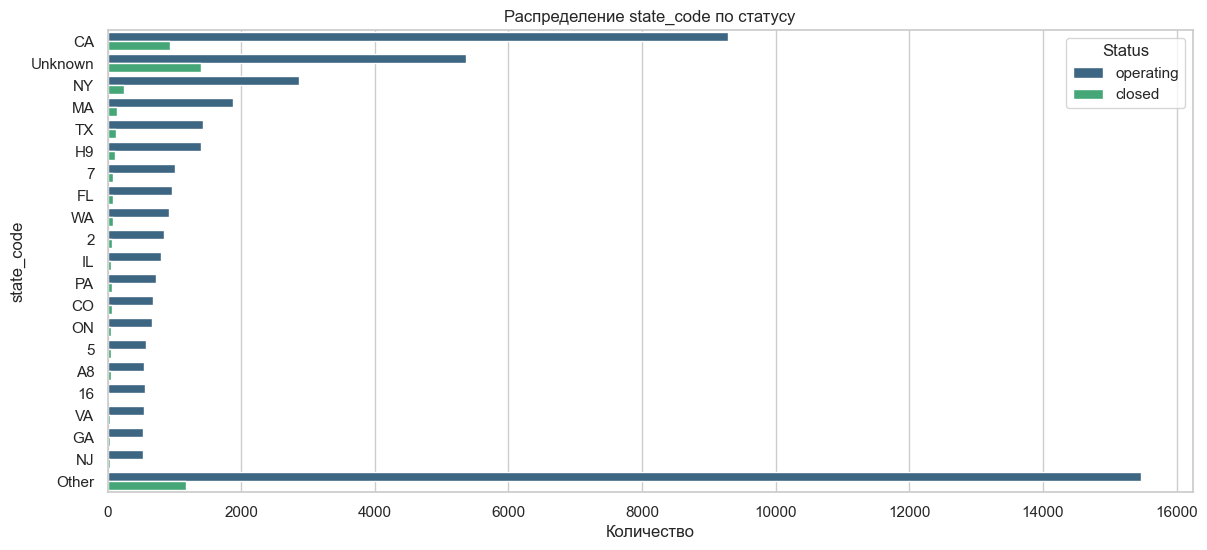

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3067016839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')


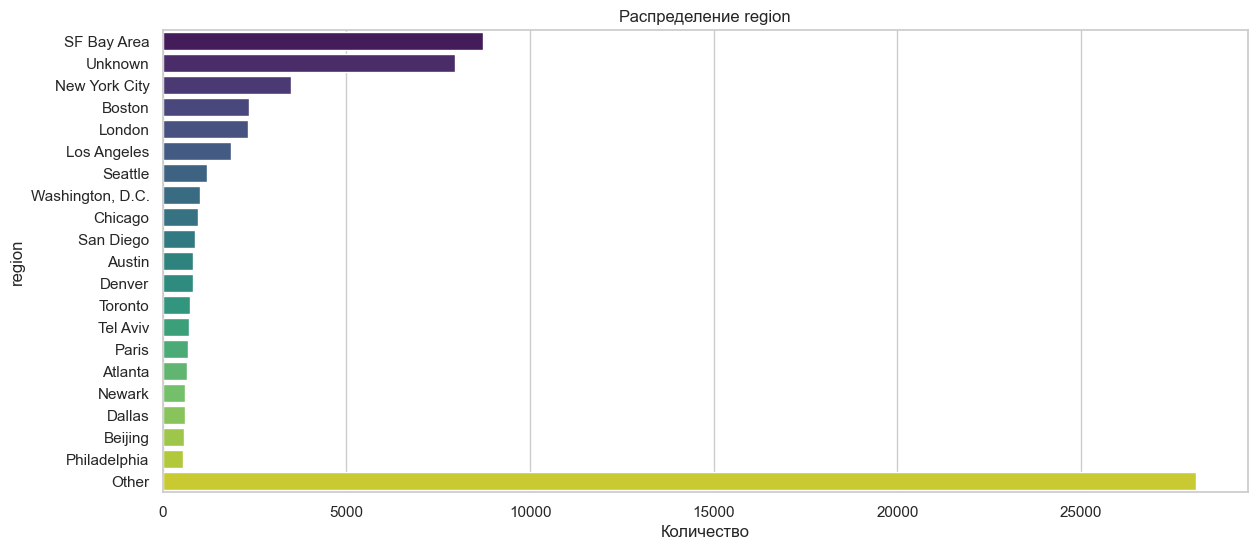

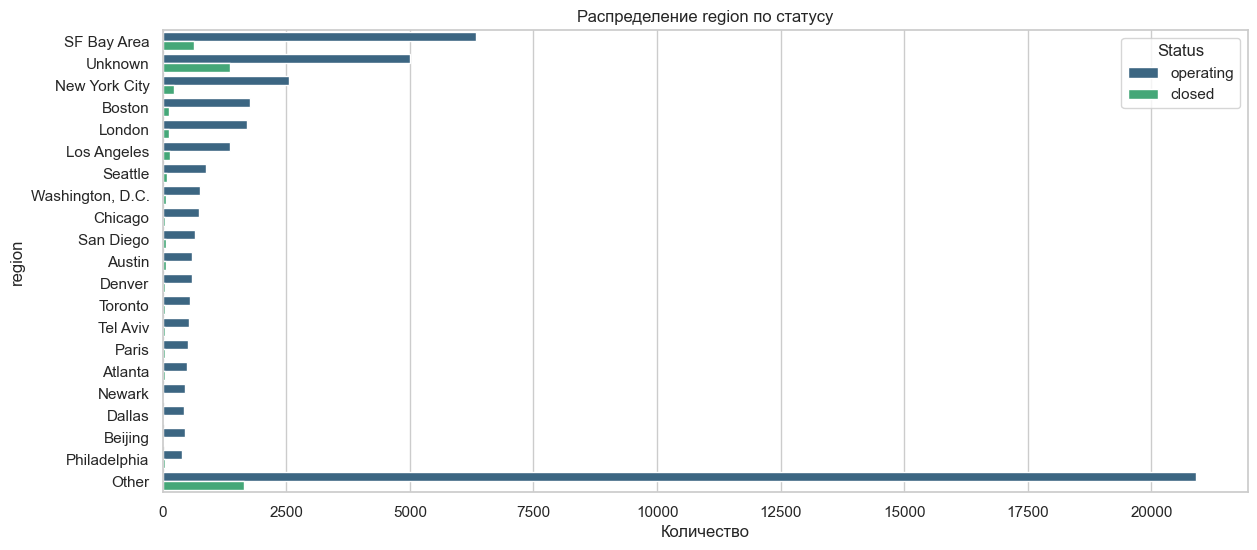

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3067016839.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='temp_category', data=combined_df, order=order, palette='viridis')


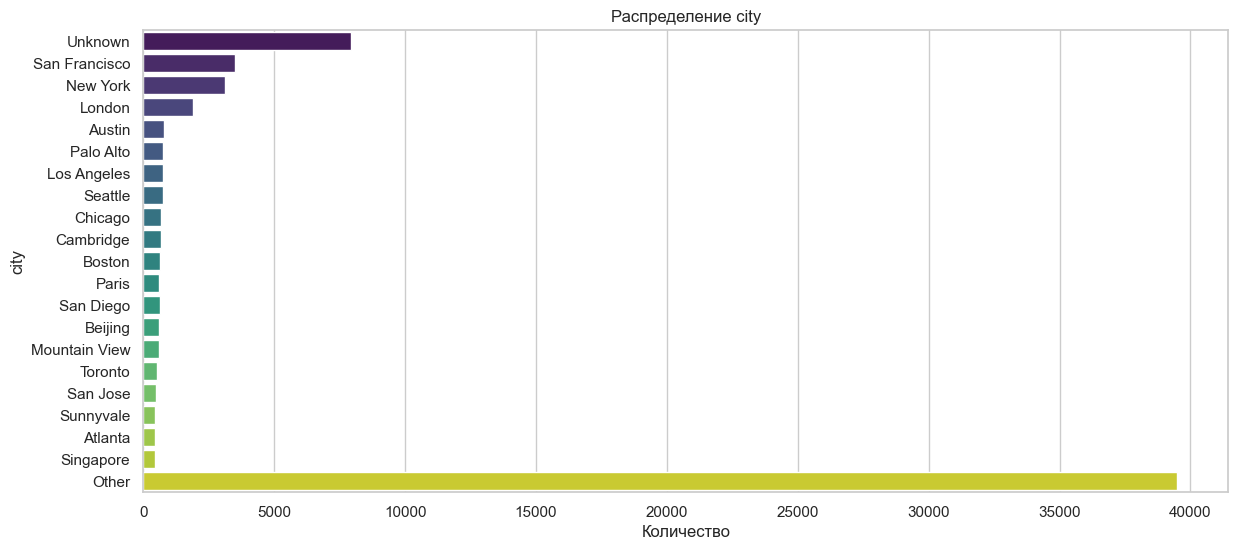

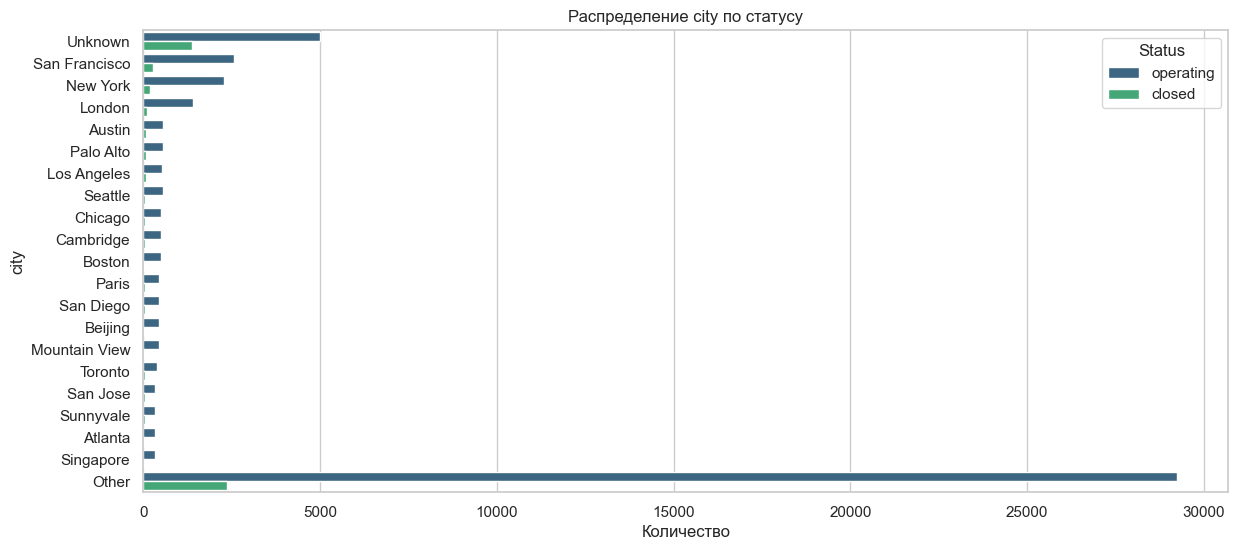

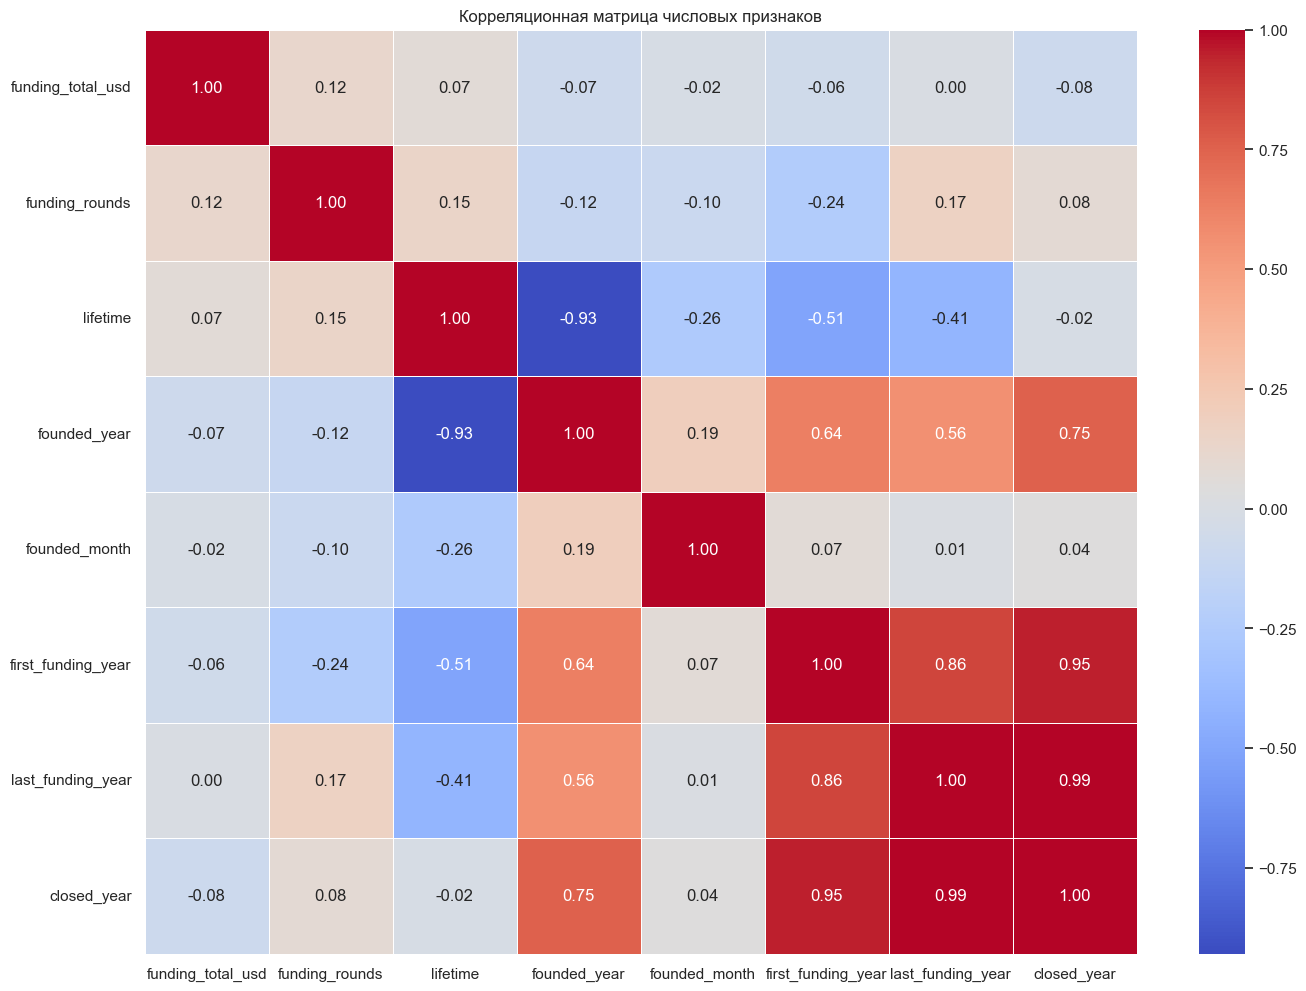

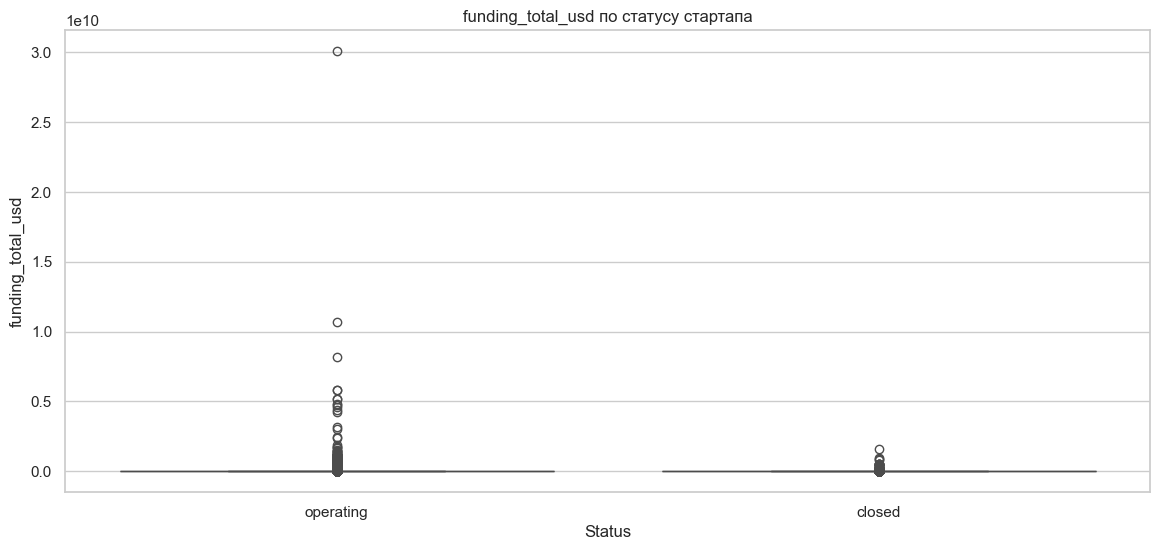

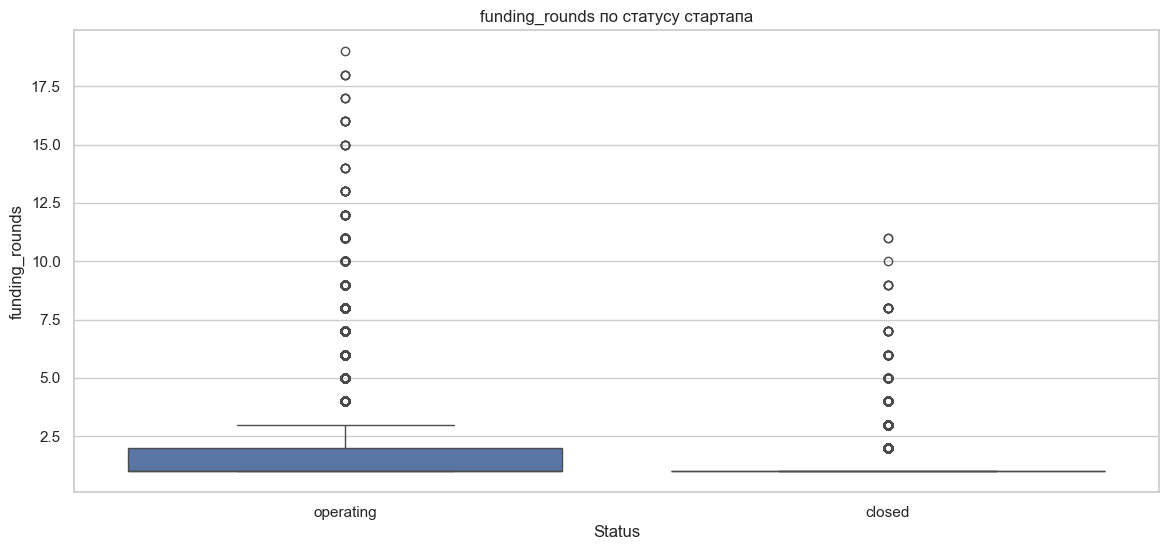

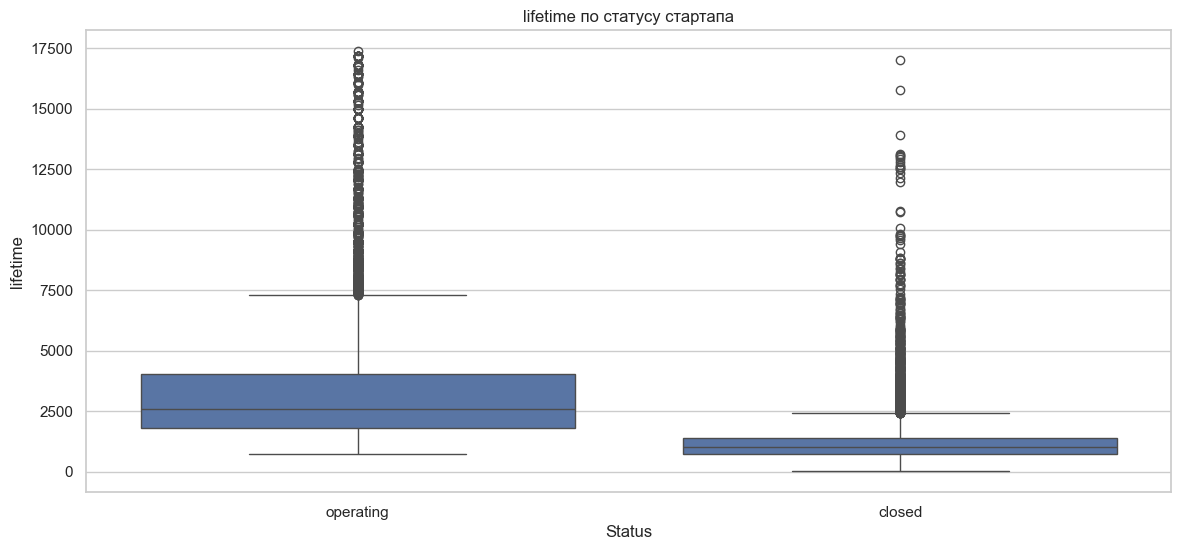

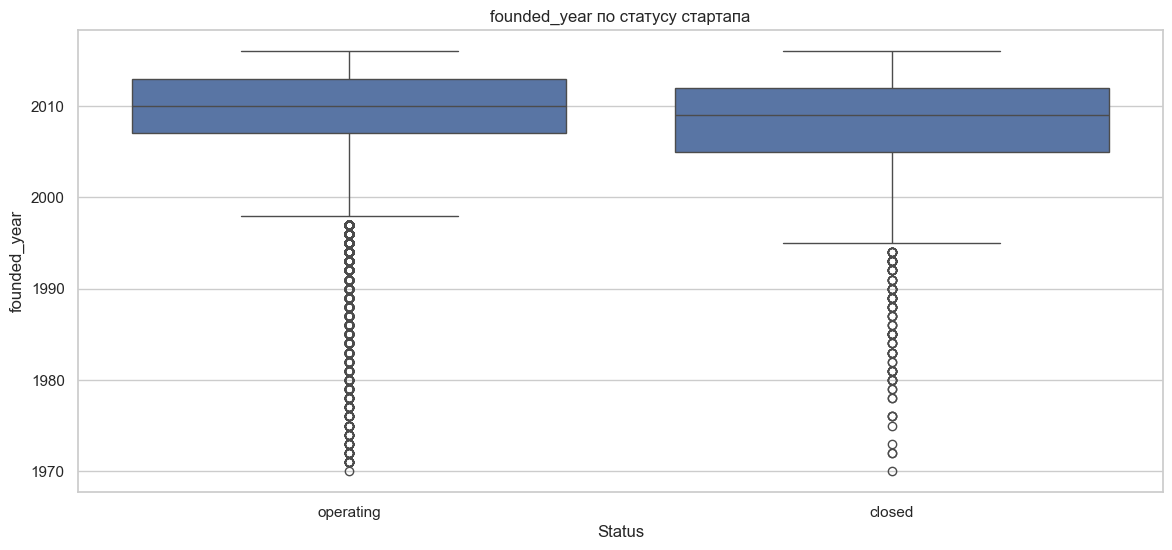

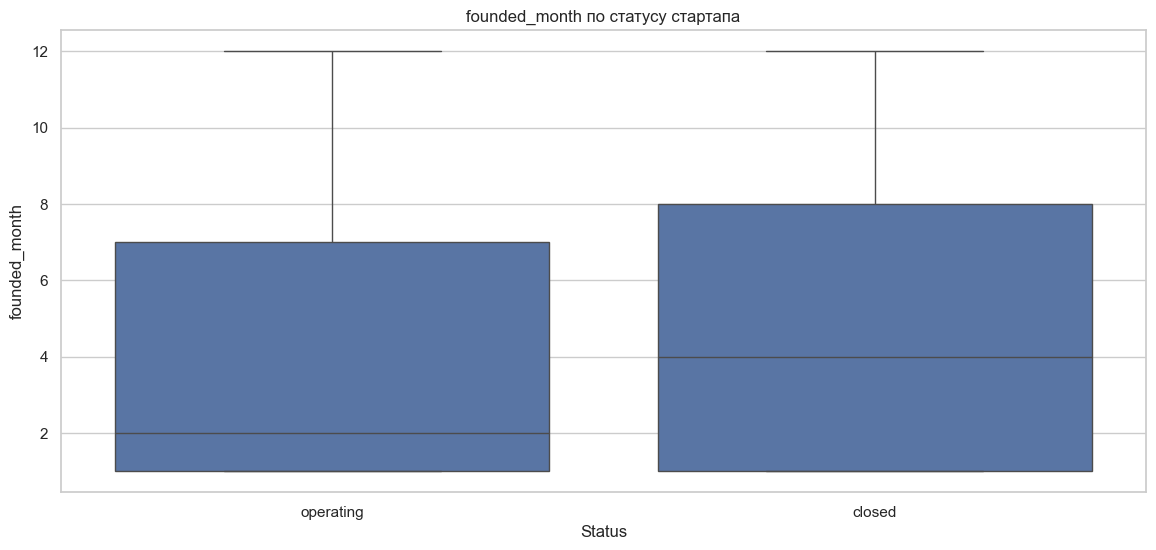

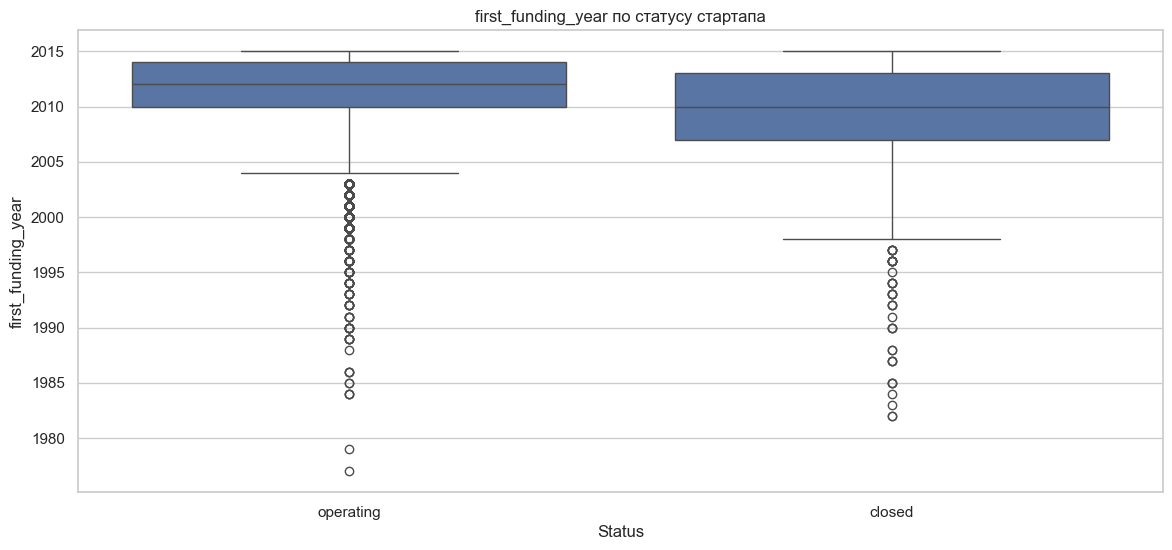

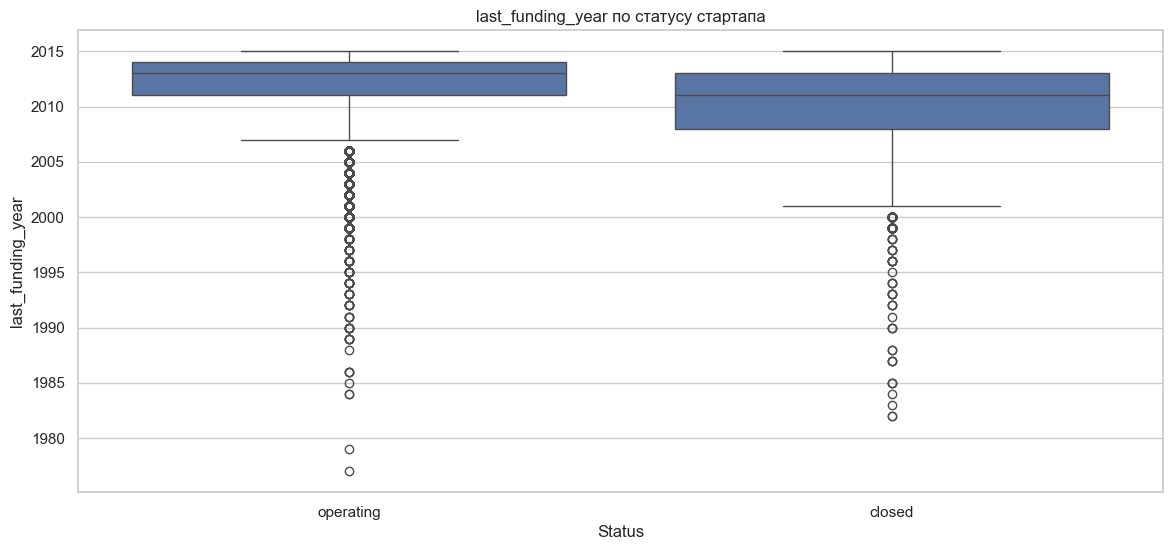

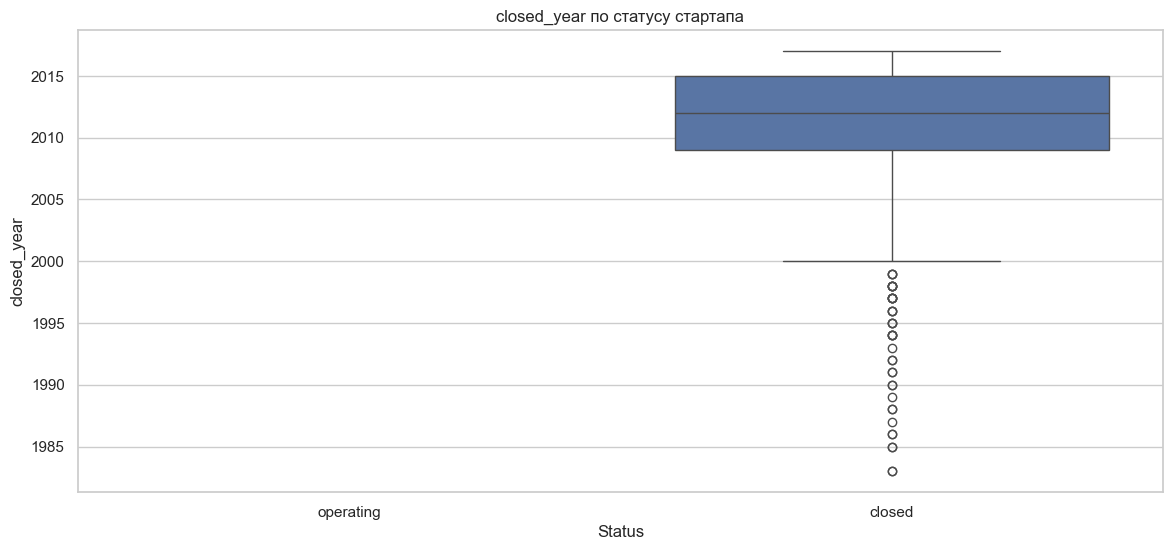

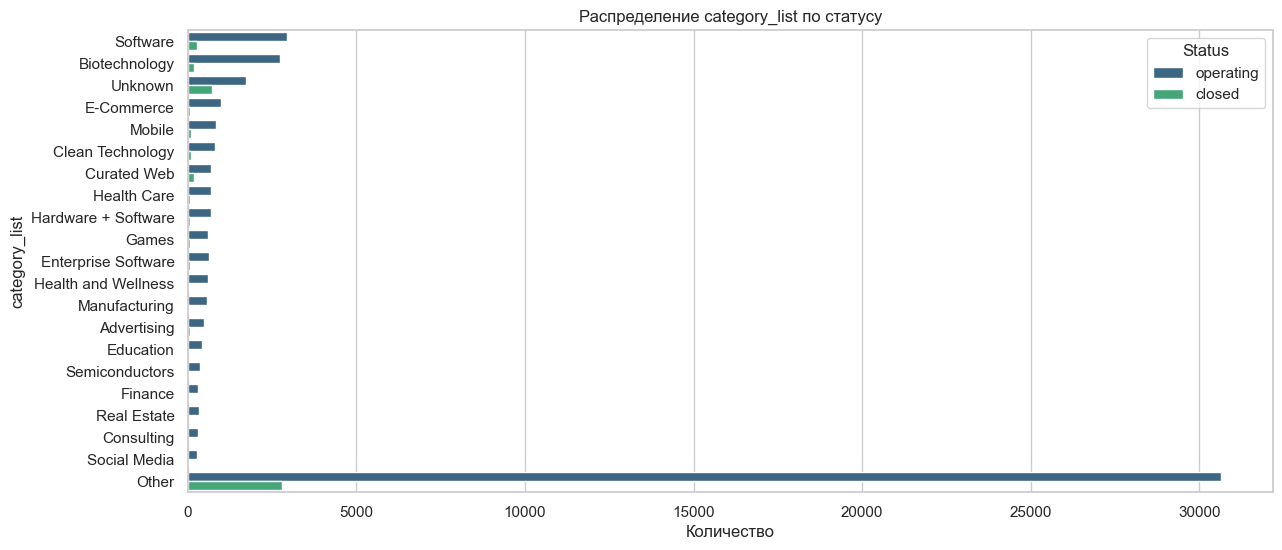

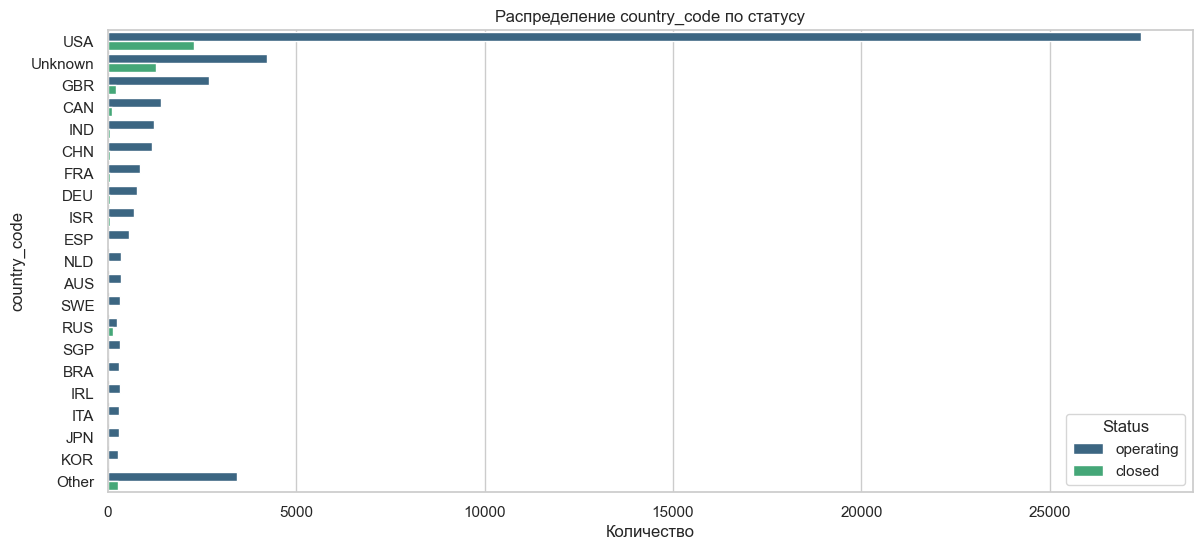

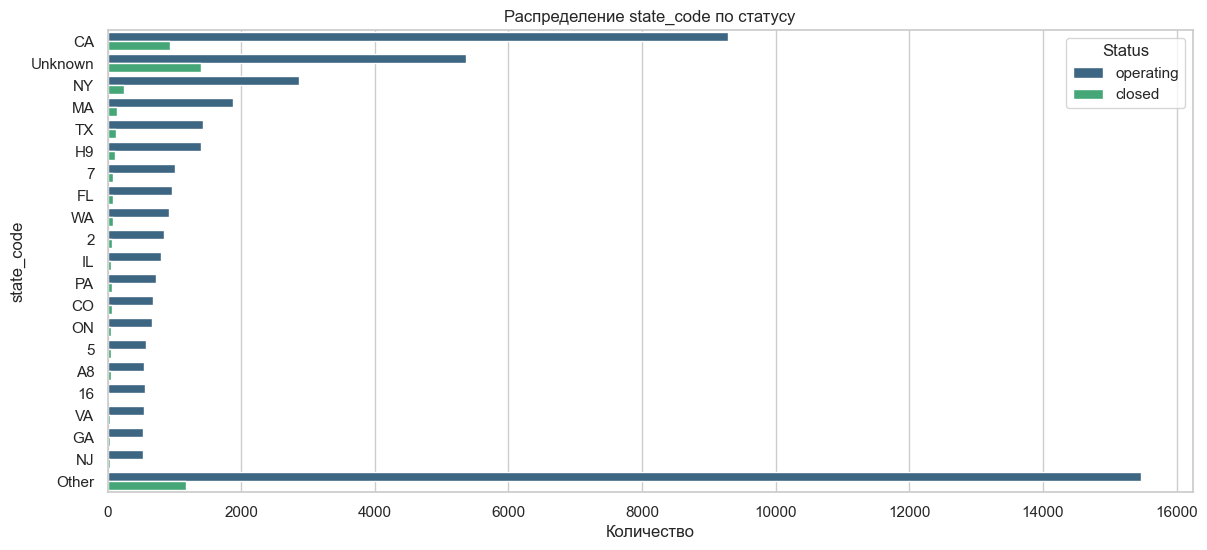

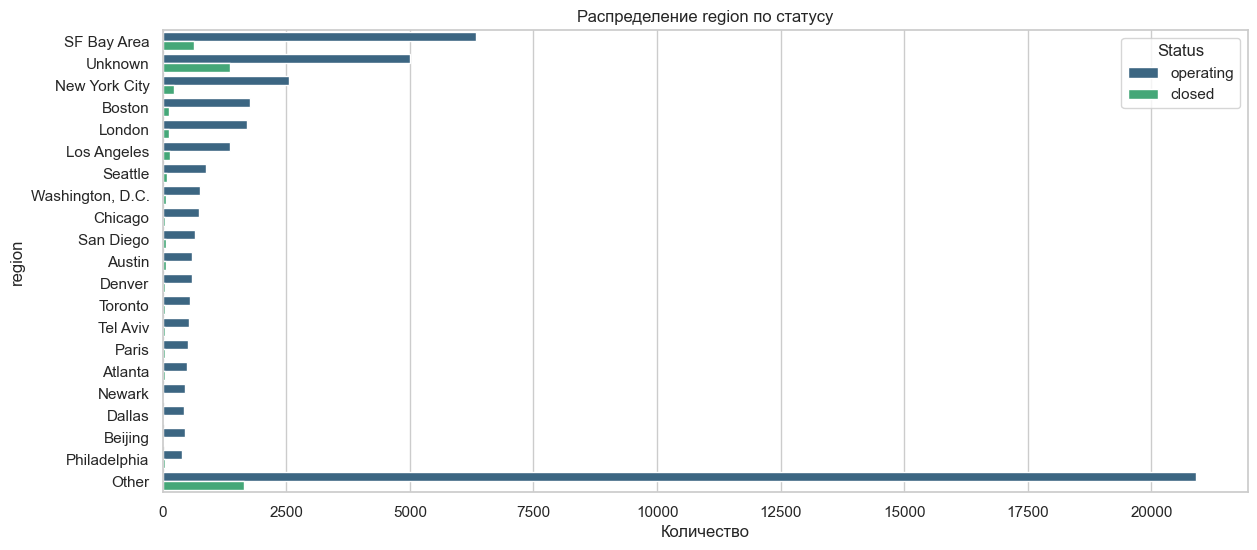

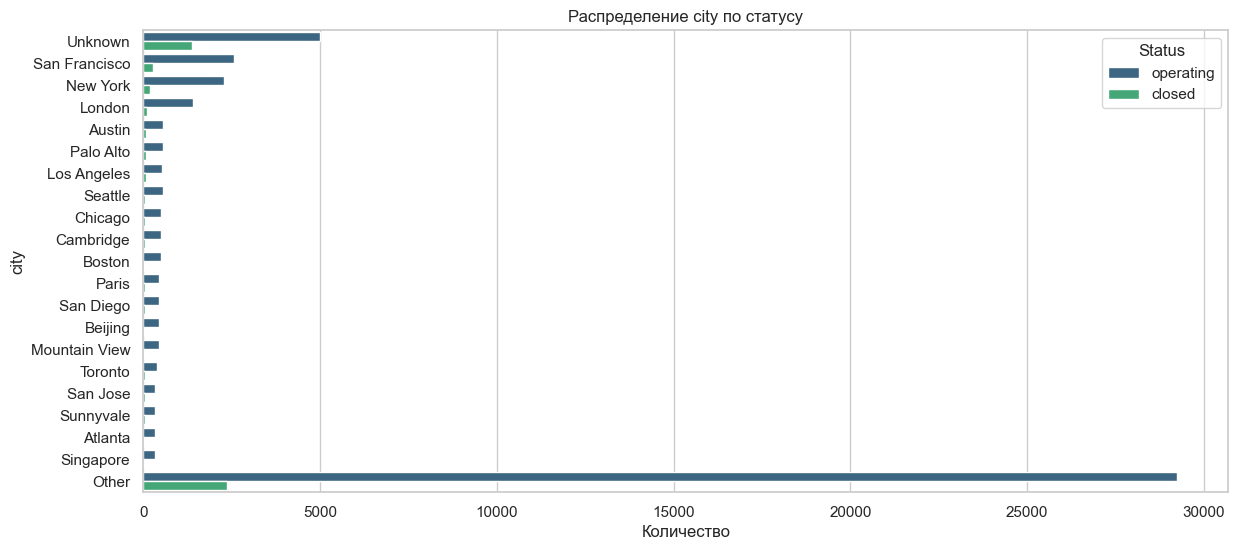

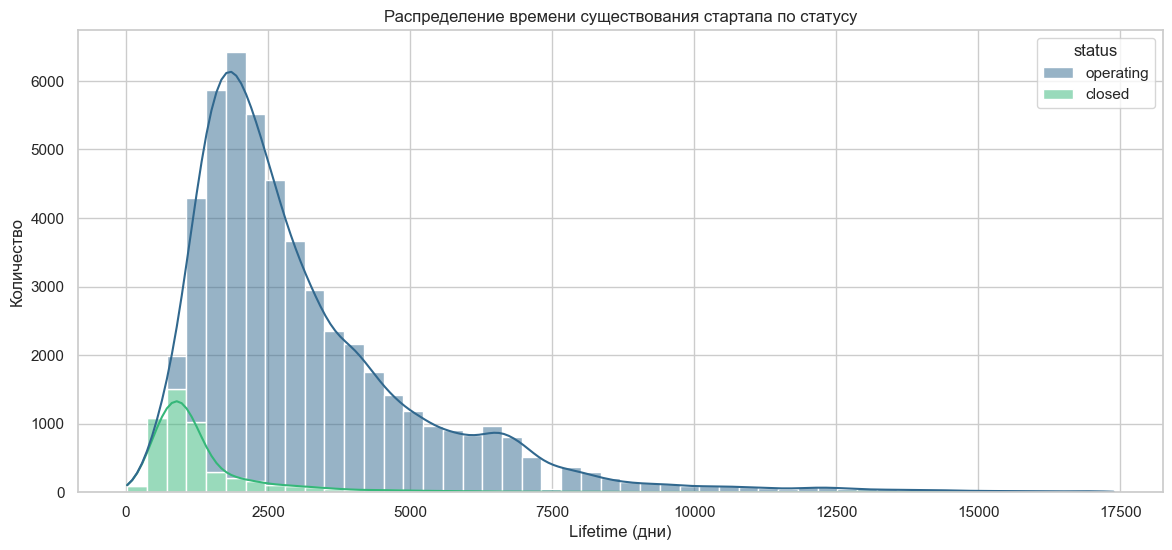

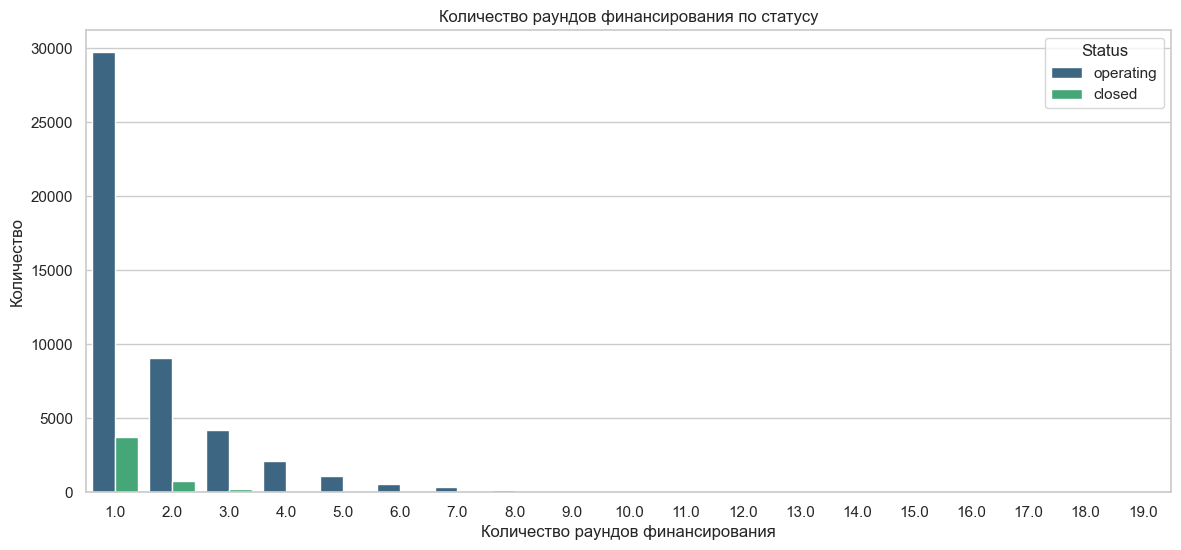

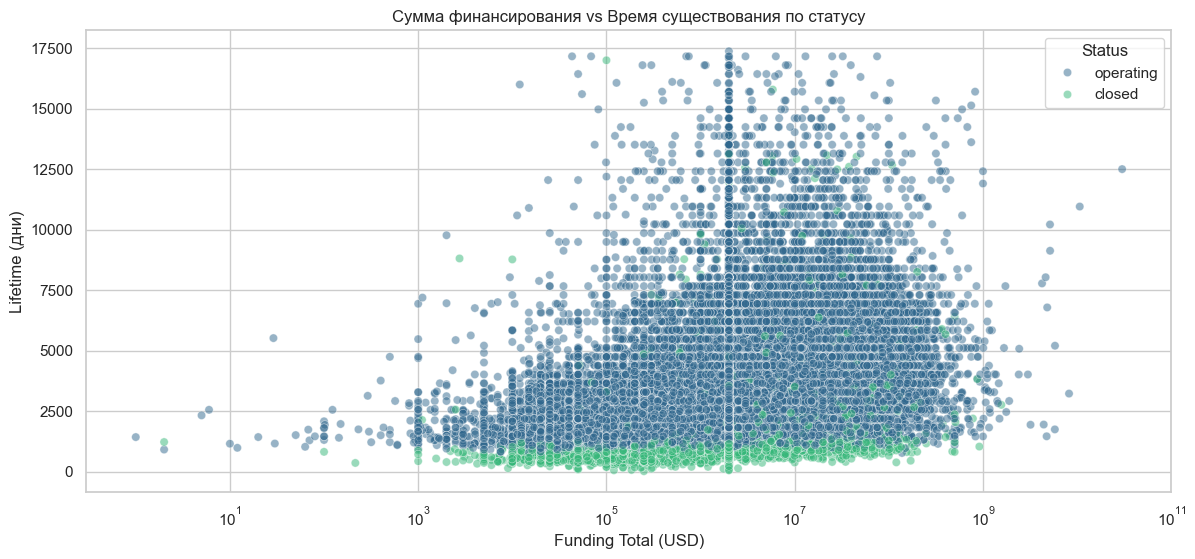

In [11]:
# Вызов функции
exploratory_analysis(train_df, test_df)

Распределение признака общая сумма финансирования в USD показывает, что большинство стартапов получили относительно небольшие суммы финансирования, так как плотность значений сконцентрирована около нуля. Это указывает на значительную долю стартапов с низким уровнем привлеченных средств, что часто характерно для компаний на ранних стадиях развития. На графике наблюдаются редкие высокие значения, свидетельствующие о небольшом числе стартапов, получивших крупные инвестиции.

Распределение общей суммы финансирования (funding_total_usd) в зависимости от статуса стартапа (действующий или закрытый). Видно, что большинство стартапов в обеих категориях получили относительно низкое финансирование, с редкими выбросами, представляющими стартапы с крупными инвестициями. Максимальные суммы финансирования наблюдаются у действующих стартапов, что может свидетельствовать о том, что более крупные инвестиции способствуют выживаемости компании. 

Распределение количества раундов финансирования (funding_rounds) показывает, что большинство стартапов в тренировочном и тестовом наборах имеют менее пяти раундов. Пик плотности приходится на 1–3 раунда, что может указывать на то, что многие стартапы либо закрываются, либо достигают стабильности после нескольких раундов финансирования.

Распределение времени существования стартапов (lifetime) показывает, что большинство стартапов имеют продолжительность жизни менее 2500 дней (около 7 лет). Пик плотности приходится на стартапы с относительно коротким сроком существования, что может указывать на высокую частоту закрытия на ранних этапах. Долгоживущие стартапы встречаются реже, а их распределение плавно уменьшается с увеличением времени жизни. 

Распределение времени существования (lifetime) по статусу стартапа показывает, что закрытые стартапы, как правило, имеют более короткий срок жизни, с пиком плотности около 1000 дней (около 3 лет). Действующие стартапы, напротив, демонстрируют более широкое распределение времени существования

Распределение года основания стартапов (founded_year) показывает тенденцию роста числа стартапов, особенно начиная с 2000-х годов, с пиком около 2010 года. Это может отражать глобальный тренд на развитие стартапов в условиях технологического прогресса и доступности венчурного капитала в последние десятилетия

Распределение года основания стартапов (founded_year) по статусу показывает, что большинство действующих стартапов были основаны после 2000 года, с резким увеличением около 2010 года. Закрытые стартапы демонстрируют рост в этот период, но их плотность значительно ниже, что может указывать на более высокую выживаемость стартапов, основанных в последние годы

Распределение месяца основания стартапов (founded_month) показывает аномально высокую плотность для первого месяца (январь), что может свидетельствовать о неполноте данных или особенностях их сбора. Остальные месяцы распределены более равномерно и имеют значительно меньшую плотность. Такое распределение может указывать на тенденцию регистрировать стартапы в начале года либо на то, что данные о дате основания могли быть заполнены примерно для некоторых компаний.

Распределение года первого раунда финансирования (first_funding_year) показывает устойчивый рост с начала 2000-х годов, с пиком около 2015 года

Распределение года последнего раунда финансирования (last_funding_year) показывает значительный рост до 2015 года

Распределение года закрытия стартапов (closed_year) показывает, что большинство закрытий произошло после 2000 года, с резким ростом в период с 2010 по 2015 годы. Это может быть связано с повышением числа основанных стартапов, а также с высокой конкуренцией и трудностями в поддержании устойчивости бизнеса

Распределение категорий стартапов (category_list) показывает, что большинство стартапов относятся к категории "Other" что указывает на разнообразие направлений (или заполнение), не вошедших в основные категории. Среди конкретных категорий лидируют "Software," "Biotechnology," и "E-Commerce," что отражает популярность технологических и биотехнологических направлений в стартап-индустрии

Распределение категорий стартапов (category_list) по статусу показывает, что большинство стартапов в категориях "Software," "Biotechnology," и "E-Commerce" продолжают действовать, в то время как закрытые стартапы присутствуют в меньших количествах во всех категориях. Категория "Other" также значительно превышает другие, что может указывать на множество стартапов в нишевых или неопределённых областях.

Распределение стартапов по странам (country_code) показывает, что подавляющее большинство стартапов зарегистрированы в США, где также наблюдается значительное количество как действующих, так и закрытых стартапов. В других странах, таких как Великобритания (GBR), Канада (CAN), Индия (IND), и Китай (CHN), число стартапов заметно ниже, но большинство из них остаются действующими

Распределение стартапов по штатам США (state_code) показывает, что большинство стартапов зарегистрированы в Калифорнии (CA), с преобладанием действующих компаний. Также значительное количество стартапов имеют неизвестный код штата ("Unknown"). Среди других штатов с высоким числом стартапов выделяются Нью-Йорк (NY), Массачусетс (MA), и Техас (TX). Остальные штаты имеют значительно меньшие количества стартапов, и в них также преобладают действующие компании

Распределение стартапов по регионам показывает, что наибольшее количество стартапов сосредоточено в районе залива Сан-Франциско (SF Bay Area), где преобладают действующие компании. Нью-Йорк и Бостон также являются крупными центрами стартапов, с преобладанием действующих компаний. Другие города, такие как Лондон, Лос-Анджелес и Сиэтл, имеют меньшие количества стартапов

Среди определённых городов лидируют Сан-Франциско и Нью-Йорк, где большинство стартапов остаются действующими. Также заметны Лондон, Остин и Пало-Альто как крупные стартап-центры с преобладанием действующих компаний

Корреляционная матрица числовых признаков показывает, что:  
lifetime имеет сильную отрицательную корреляцию с founded_year (-0.93), что указывает на то, что стартапы, основанные позже, имеют меньшую продолжительность существования до закрытия.  
first_funding_year, last_funding_year и closed_year сильно коррелируют друг с другом (значения около 0.95 и выше), что отражает взаимосвязь между датами финансирования и закрытия стартапов.  
funding_rounds и last_funding_year имеют умеренную положительную корреляцию (0.17), что может указывать на то, что поздние даты последнего финансирования связаны с большим числом раундов.  
funding_total_usd имеет слабую корреляцию с другими признаками, что говорит о независимости общего объема финансирования от большинства других параметров.  
Корреляции между другими признаками относительно слабы, что указывает на низкую зависимость между ними.  

Диаграмма рассеяния показывает зависимость между общей суммой финансирования (Funding Total (USD)) и временем существования стартапа (Lifetime (дни)) в разрезе статуса (действующий или закрытый). Видно, что более продолжительное время существования свойственно стартапам с более высокими уровнями финансирования, особенно для действующих компаний. Закрытые стартапы, как правило, имеют более короткий период жизни и меньшее финансирование

### 4. Разработка новых синтетических признаков

In [12]:
def create_synthetic_features(train_df, test_df):
    """
    Создаёт новые синтетические признаки для обучающего и тестового наборов данных.
    
    Параметры:
    - train_df (pd.DataFrame): Обучающий набор данных.
    - test_df (pd.DataFrame): Тестовый набор данных.
    
    Возвращает:
    - train_df (pd.DataFrame): Обновлённый обучающий набор данных с новыми признаками.
    - test_df (pd.DataFrame): Обновлённый тестовый набор данных с новыми признаками.
    """
    from sklearn.impute import SimpleImputer

    # Дата формирования выгрузки
    cutoff_date = datetime.strptime('2018-01-01', '%Y-%m-%d')
    
    def add_founded_at(df, is_train=True):
        """
        Восстанавливает столбец 'founded_at' для тестового набора данных, используя 'lifetime'.
        """
        if not is_train:
            # В тестовом наборе данных 'founded_at' отсутствует
            # Восстанавливаем 'founded_at' как cutoff_date - lifetime
            df['founded_at'] = cutoff_date - pd.to_timedelta(df['lifetime'], unit='d')
        return df

    def add_time_intervals(df):
        """
        Добавляет временные интервалы в DataFrame.
        """
        # Преобразование строковых дат в datetime (если еще не преобразованы)
        date_columns = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
        for col in date_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
            else:
                # Если столбца нет, создаём его с NaT
                df[col] = pd.NaT
        
        # Время между основанием и первым раундом финансирования
        df['time_to_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
        
        # Время между первым и последним раундом финансирования
        df['time_between_fundings'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
        
        # Время между основанием и последним раундом финансирования
        df['time_to_last_funding'] = (df['last_funding_at'] - df['founded_at']).dt.days
        
        return df

    def add_statistical_features(df):
        """
        Добавляет статистические признаки в DataFrame.
        """
        # Количество категорий
        df['num_categories'] = df['category_list'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
        
        # Длина списка категорий
        df['category_length'] = df['category_list'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
        
        return df

    def add_interaction_features(df):
        """
        Добавляет взаимодействующие признаки в DataFrame.
        """
        # Средняя сумма финансирования за раунд
        df['avg_funding_per_round'] = df['funding_total_usd'] / df['funding_rounds']
        
        # Заполнение бесконечных или нечисловых значений
        df['avg_funding_per_round'].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Взаимодействие между количеством раундов и средней суммой финансирования
        df['funding_rounds_x_avg_funding'] = df['funding_rounds'] * df['avg_funding_per_round']
        
        return df

    # Применение функций к обучающему набору данных
    train_df = add_time_intervals(train_df)
    train_df = add_statistical_features(train_df)
    train_df = add_interaction_features(train_df)
    
    # Восстановление 'founded_at' для тестового набора данных
    test_df = add_founded_at(test_df, is_train=False)
    
    # Применение функций к тестовому набору данных
    test_df = add_time_intervals(test_df)
    test_df = add_statistical_features(test_df)
    test_df = add_interaction_features(test_df)
    
    # Определение новых числовых признаков
    new_numeric_features = ['time_to_first_funding', 'time_between_fundings', 'time_to_last_funding',
                            'avg_funding_per_round', 'num_categories', 'category_length',
                            'funding_rounds_x_avg_funding']
    
    # Заполнение пропусков для новых признаков медианой
    numeric_imputer = SimpleImputer(strategy='median')
    train_df[new_numeric_features] = numeric_imputer.fit_transform(train_df[new_numeric_features])
    test_df[new_numeric_features] = numeric_imputer.transform(test_df[new_numeric_features])
    
    return train_df, test_df

In [13]:
train_df, test_df = create_synthetic_features(train_df, test_df)
print("Синтетические признаки созданы.")

Синтетические признаки созданы.


### 5. Проверка на мультиколлинеарность

In [14]:
def check_multicollinearity(train_df, threshold=5.0):
    """
    Проверяет мультиколлинеарность признаков в обучающем наборе данных с помощью VIF.
    
    Параметры:
    - train_df (pd.DataFrame): Обучающий набор данных.
    - threshold (float): Пороговое значение VIF для удаления признаков.
    
    Возвращает:
    - high_vif_features (list): Список признаков с VIF выше порога.
    - vif_df (pd.DataFrame): Таблица VIF для всех признаков.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
    
    # Выбираем только числовые признаки для расчёта VIF
    # Исключаем 'lifetime', если он не нужен для дальнейшего анализа
    numeric_df = train_df.select_dtypes(include=[np.number]).drop(columns=['lifetime'], errors='ignore')
    
    # Добавляем константу для VIF
    numeric_df_const = add_constant(numeric_df)
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_df_const.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df_const.values, i)
                       for i in range(numeric_df_const.shape[1])]
    
    # Исключаем константу из результатов
    vif_data = vif_data[vif_data['feature'] != 'const']
    
    # Определение признаков с высоким VIF
    high_vif_features = vif_data[vif_data['VIF'] > threshold]['feature'].tolist()
    
    print("Варианс инфляции (VIF) для признаков:")
    print(vif_data)
    print("\nПризнаки с VIF выше порога ({}): {}".format(threshold, high_vif_features))
    
    return high_vif_features, vif_data

In [15]:
# Выполнение проверки на мультиколлинеарность
high_vif_features, vif_df = check_multicollinearity(train_df, threshold=5.0)

# Если есть признаки с высоким VIF, удаляем их из наборов данных
if high_vif_features:
    train_df = train_df.drop(columns=high_vif_features)
    test_df = test_df.drop(columns=high_vif_features)
    print(f"Удалены признаки с высоким VIF: {high_vif_features}")
else:
    print("Признаки с высоким VIF не обнаружены.")

Варианс инфляции (VIF) для признаков:
                        feature           VIF
0             funding_total_usd           inf
1                funding_rounds  2.489648e+00
2         time_to_first_funding  2.817295e+05
3         time_between_fundings  1.913530e+07
4          time_to_last_funding  1.240055e+05
5                num_categories  4.750682e+00
6               category_length  1.020313e+00
7         avg_funding_per_round  2.253437e+00
8  funding_rounds_x_avg_funding           inf

Признаки с VIF выше порога (5.0): ['funding_total_usd', 'time_to_first_funding', 'time_between_fundings', 'time_to_last_funding', 'funding_rounds_x_avg_funding']
Удалены признаки с высоким VIF: ['funding_total_usd', 'time_to_first_funding', 'time_between_fundings', 'time_to_last_funding', 'funding_rounds_x_avg_funding']


D:\programs\python\anakonda\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### 6. Отбор финального набора обучающих признаков

In [16]:
# Определение признаков и целевой переменной
X = train_df.drop(['status', 'name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)
y = train_df['status'].map({'operating': 0, 'closed': 1})  # Преобразование целевой переменной в числовой формат

# Определение доступных признаков после удаления высоко коррелированных
numeric_features = [
    'funding_rounds', 
    'lifetime', 
    'num_categories', 
    'category_length', 
    'avg_funding_per_round'
]
categorical_features = ['country_code', 'state_code', 'region', 'city']  # исключаем 'category_list'

# Проверка наличия признаков в DataFrame
numeric_features_present = [feature for feature in numeric_features if feature in X.columns]
categorical_features_present = [feature for feature in categorical_features if feature in X.columns]

# Разделение на числовые и категориальные признаки
X_num = X[numeric_features_present]
X_cat = X[categorical_features_present]

# Ограничение количества уникальных категорий для ускорения One-Hot Encoding
top_n = 10  # Количество топ категорий для каждого признака
for col in categorical_features_present:
    top_categories = X_cat[col].value_counts().nlargest(top_n).index
    X_cat[col] = X_cat[col].apply(lambda x: x if x in top_categories else 'Other')

# Кодирование категориальных признаков с помощью One-Hot Encoding
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True, dummy_na=False)

# Объединение числовых и закодированных категориальных признаков
X_processed = pd.concat([X_num, X_cat_encoded], axis=1)

# Отбор признаков с помощью SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_processed, y)

# Получение названий выбранных признаков
selected_indices = selector.get_support(indices=True)
selected_feature_names = X_processed.columns[selected_indices]

print("Отобранные признаки:")
print(selected_feature_names.tolist())

# Обновление обучающего набора данных с отобранными признаками
train_df_final = pd.DataFrame(X_selected, columns=selected_feature_names)
train_df_final['status'] = y.values

C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3291655826.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].apply(lambda x: x if x in top_categories else 'Other')
C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3291655826.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].apply(lambda x: x if x in top_categories else 'Other')
C:\Users\Lekar\AppData\Local\Temp\ipykernel_14164\3291655826.py:27: SettingWithCopyWarning: 
A value is trying to be set on a 

Отобранные признаки:
['funding_rounds', 'lifetime', 'num_categories', 'category_length', 'avg_funding_per_round', 'country_code_IND', 'country_code_USA', 'country_code_Unknown', 'state_code_CA', 'state_code_FL', 'state_code_NY', 'state_code_Other', 'state_code_Unknown', 'state_code_WA', 'region_Other', 'region_SF Bay Area', 'region_Unknown', 'city_London', 'city_Other', 'city_Unknown']


In [17]:
print(f"Размер финального обучающего набора данных: {train_df_final.shape}")

Размер финального обучающего набора данных: (52516, 21)


### 7. Выбор и обучение моделей

In [18]:
# Шаг 7. Выбор и обучение моделей (без SVC)

# Определение признаков и целевой переменной
X = train_df_final.drop('status', axis=1)
y = train_df_final['status']

# Стратегия кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Определение моделей и их гиперпараметров (исключаем SVC)
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50]
        }
    },
    'CatBoost': {
        'model': cb.CatBoostClassifier(verbose=0, random_state=42),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.01, 0.1],
            'depth': [6, 10]
        }
    }
}

# Словарь для хранения лучших моделей и их оценок
best_models = {}
best_scores = {}

# Обучение и подбор гиперпараметров для каждой модели
for name, config in models.items():
    print(f"Обучение модели: {name}")
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    best_scores[name] = grid_search.best_score_
    print(f"Лучшая оценка AUC: {grid_search.best_score_:.4f}")
    print(f"Лучшие параметры: {grid_search.best_params_}\n")

# Вывод лучших моделей и их AUC
print("Лучшие модели и их оценки AUC:")
for name, score in best_scores.items():
    print(f"{name}: AUC = {score:.4f}")

Обучение модели: RandomForest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшая оценка AUC: 0.9108
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

Обучение модели: GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшая оценка AUC: 0.9364
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Обучение модели: LogisticRegression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Лучшая оценка AUC: 0.8800
Лучшие параметры: {'C': 0.1, 'penalty': 'l2'}

Обучение модели: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits


D:\programs\python\anakonda\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшая оценка AUC: 0.9324
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Обучение модели: LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4917, number of negative: 47599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 745
[LightGBM] [Info] Number of data points in the train set: 52516, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093629 -> initscore=-2.270113
[LightGBM] [Info] Start training from score -2.270113
Лучшая оценка AUC: 0.9357
Лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}

Обучение модели: CatBoost
Fitting 5 folds for each of 8 candidates

### 8. Итоговая оценка качества предсказания лучшей модели

In [26]:
# 1. Переопределяем признаки и целевую переменную, используя обучающие данные
X = train_df.drop(['status', 'name', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], axis=1)
y = train_df['status'].map({'operating': 0, 'closed': 1})  # Преобразуем целевую переменную в числовой формат

# Используемые признаки
numeric_features = [
    'funding_rounds', 
    'lifetime', 
    'num_categories', 
    'category_length', 
    'avg_funding_per_round'
]
categorical_features = ['country_code', 'state_code', 'region', 'city']

# Проверяем наличие признаков
numeric_features_present = [feature for feature in numeric_features if feature in X.columns]
categorical_features_present = [feature for feature in categorical_features if feature in X.columns]

# Разделяем числовые и категориальные признаки
X_num = X[numeric_features_present]
X_cat = X[categorical_features_present].copy()

# Ограничиваем количество уникальных категорий для One-Hot Encoding
top_n = 10  # Количество топ категорий для сохранения
for col in categorical_features_present:
    top_categories = X_cat[col].value_counts().nlargest(top_n).index
    X_cat.loc[:, col] = X_cat[col].apply(lambda x: x if x in top_categories else 'Other')

# One-Hot Encoding для категориальных признаков
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True, dummy_na=False)

# Объединяем числовые и закодированные категориальные признаки
X_processed = pd.concat([X_num, X_cat_encoded], axis=1)

# Сохраняем список всех названий признаков после кодирования
all_feature_names = X_processed.columns.tolist()

# Отбор признаков с помощью SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k=20)
X_selected = selector.fit_transform(X_processed, y)

# Получаем названия выбранных признаков
selected_indices = selector.get_support(indices=True)
selected_feature_names = [all_feature_names[i] for i in selected_indices]

print("Отобранные признаки:")
print(selected_feature_names)

# 2. Используем обученную модель из Шага 7
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f"Лучшая модель: {best_model_name} с AUC = {best_scores[best_model_name]:.4f}")

# Дополнительная оценка на обучающих данных (опционально)
cv_scores = cross_val_score(best_model, X_selected, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Кросс-валидация ROC AUC для {best_model_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

y_pred_proba = best_model.predict_proba(X_selected)[:, 1]
y_pred = best_model.predict(X_selected)

roc_auc = roc_auc_score(y, y_pred_proba)
print(f"ROC AUC на обучающем наборе: {roc_auc:.4f}")

print("Отчёт классификации на обучающем наборе:")
print(classification_report(y, y_pred))

print("Матрица ошибок на обучающем наборе:")
print(confusion_matrix(y, y_pred))

# 3. Обработка тестового набора данных

# Копируем test_df для обработки
test_df_processed = test_df.copy()

# Убеждаемся, что та же обработка применяется к тестовым данным
# Обрабатываем пропущенные значения в числовых признаках, если необходимо
# Для простоты предполагаем, что пропущенные значения были обработаны в предыдущих шагах

# Заменяем редкие категории на 'Other' в тестовых данных
for col in categorical_features_present:
    top_categories = X_cat[col].value_counts().nlargest(top_n).index
    test_df_processed.loc[:, col] = test_df_processed[col].apply(lambda x: x if x in top_categories else 'Other')

# One-Hot Encoding для тестовых данных
test_X_cat_encoded = pd.get_dummies(test_df_processed[categorical_features_present], drop_first=True, dummy_na=False)

# Обработка числовых признаков в тестовых данных
test_X_num = test_df_processed[numeric_features_present]

# Объединяем числовые и закодированные категориальные признаки в тестовых данных
test_X_processed = pd.concat([test_X_num, test_X_cat_encoded], axis=1)

# Убеждаемся, что тестовые данные имеют те же признаки, что и обучающие
# Добавляем недостающие столбцы в тестовые данные и заполняем их нулями
missing_cols = set(all_feature_names) - set(test_X_processed.columns)
for col in missing_cols:
    test_X_processed[col] = 0

# Удаляем лишние столбцы в тестовых данных
extra_cols = set(test_X_processed.columns) - set(all_feature_names)
if extra_cols:
    test_X_processed = test_X_processed.drop(columns=extra_cols)
    print(f"Удалены лишние признаки из тестовых данных: {extra_cols}")

# Переупорядочиваем столбцы в тестовых данных, чтобы они соответствовали обучающим
test_X_processed = test_X_processed[all_feature_names]

# Применяем SelectKBest к тестовым данным
X_test_selected = selector.transform(test_X_processed)

# 4. Предсказание классов на тестовом наборе данных
test_pred = best_model.predict(X_test_selected)

# 5. Подготовка файла для отправки

# Отображаем предсказанные классы в 'operating' и 'closed'
status_mapping = {0: 'operating', 1: 'closed'}
test_pred_labels = pd.Series(test_pred, index=test_df_processed.index).map(status_mapping)

# Создаём финальный DataFrame для отправки
submission_df = pd.DataFrame({
    'name': test_df_processed['name'],
    'status': test_pred_labels
})

# Проверяем формат отправки
print("Пример файла для отправки:")
print(submission_df.head())

# Сохраняем файл для отправки
submission_file_path = "submission_step8.csv"
submission_df.to_csv(submission_file_path, index=False)
print(f"Файл для отправки сохранён по пути: {submission_file_path}")

# 6. Сохраняем модель для будущего использования
model_file_path = f"best_model_{best_model_name}.joblib"
joblib.dump(best_model, model_file_path)
print(f"Модель {best_model_name} сохранена по пути: {model_file_path}")

Отобранные признаки:
['funding_rounds', 'lifetime', 'num_categories', 'category_length', 'avg_funding_per_round', 'country_code_CHN', 'country_code_FRA', 'country_code_USA', 'country_code_Unknown', 'state_code_Other', 'state_code_TX', 'state_code_Unknown', 'region_Other', 'region_SF Bay Area', 'region_Unknown', 'city_London', 'city_Los Angeles', 'city_Other', 'city_Palo Alto', 'city_Unknown']
Лучшая модель: GradientBoosting с AUC = 0.9364
Кросс-валидация ROC AUC для GradientBoosting: 0.9368 ± 0.0030


D:\programs\python\anakonda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
D:\programs\python\anakonda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


ROC AUC на обучающем наборе: 0.9568
Отчёт классификации на обучающем наборе:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     47599
           1       0.89      0.60      0.71      4917

    accuracy                           0.96     52516
   macro avg       0.92      0.79      0.84     52516
weighted avg       0.95      0.96      0.95     52516

Матрица ошибок на обучающем наборе:
[[47223   376]
 [ 1979  2938]]
Пример файла для отправки:
                     name     status
0              Crystalsol  operating
1        JBI Fish & Wings  operating
2                COINPLUS  operating
3  Imagine Communications  operating
4                   DNA13  operating
Файл для отправки сохранён по пути: submission_step8.csv
Модель GradientBoosting сохранена по пути: best_model_GradientBoosting.joblib


D:\programs\python\anakonda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


### 9. Анализ важности ее признаков

Топ-10 наиболее важных признаков:
                  Feature  Importance
1                lifetime    0.870015
4   avg_funding_per_round    0.054419
3         category_length    0.029293
0          funding_rounds    0.014206
16       city_Los Angeles    0.006001
5        country_code_CHN    0.004774
14         region_Unknown    0.003770
19           city_Unknown    0.003186
6        country_code_FRA    0.001891
15            city_London    0.001776


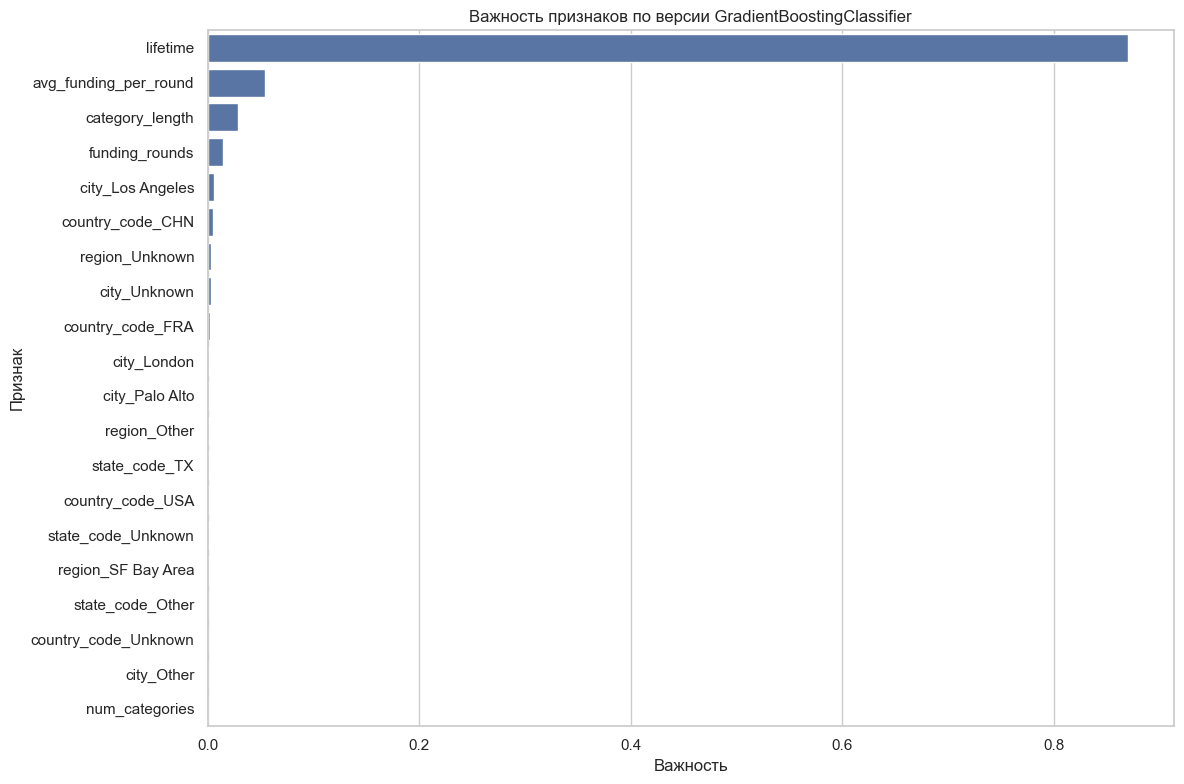


Анализ важности признаков:
Признак 'lifetime' имеет важность 0.8700
Признак 'avg_funding_per_round' имеет важность 0.0544
Признак 'category_length' имеет важность 0.0293
Признак 'funding_rounds' имеет важность 0.0142
Признак 'city_Los Angeles' имеет важность 0.0060
Признак 'country_code_CHN' имеет важность 0.0048
Признак 'region_Unknown' имеет важность 0.0038
Признак 'city_Unknown' имеет важность 0.0032
Признак 'country_code_FRA' имеет важность 0.0019
Признак 'city_London' имеет важность 0.0018
Признак 'city_Palo Alto' имеет важность 0.0018
Признак 'region_Other' имеет важность 0.0016
Признак 'state_code_TX' имеет важность 0.0014
Признак 'country_code_USA' имеет важность 0.0014
Признак 'state_code_Unknown' имеет важность 0.0013
Признак 'region_SF Bay Area' имеет важность 0.0011
Признак 'state_code_Other' имеет важность 0.0008
Признак 'country_code_Unknown' имеет важность 0.0007
Признак 'city_Other' имеет важность 0.0006
Признак 'num_categories' имеет важность 0.0000


In [27]:
# 1. Получение важности признаков из модели
feature_importances = best_model.feature_importances_

# Создание DataFrame для удобства
importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances
})

# Сортировка признаков по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Вывод топ-10 наиболее важных признаков
print("Топ-10 наиболее важных признаков:")
print(importance_df.head(10))

# 2. Визуализация важности признаков
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков по версии GradientBoostingClassifier')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# 3. Анализ результатов
print("\nАнализ важности признаков:")
for index, row in importance_df.iterrows():
    print(f"Признак '{row['Feature']}' имеет важность {row['Importance']:.4f}")

### 10. Подготовка отчета по исследованию

Целью данного исследования было разработать модель, способную предсказать, какие стартапы закроются на основе исторических данных. Данные предоставлены в рамках соревнования на платформе Kaggle и включают информацию о стартапах, функционировавших в период с 1970 по 2018 годы. Основная задача заключалась в анализе данных, разработке новых признаков и построении модели с высокой точностью предсказания закрытия стартапов.  

**Шаг 1. Загрузка и ознакомление с данными**  
Данные: Датасет состоит из тренировочного набора (около 53 000 записей) и тестового набора (около 13 000 записей).  
Целевой признак: status, принимающий значения 'operating' (действующий) или 'closed' (закрыт).  
Обзор данных:  
Наборы данных содержат как числовые, так и категориальные признаки.  
Обнаружены пропущенные значения в ряде признаков, включая category_list, funding_total_usd, и географические признаки.  
Выявлены несоответствия в данных, требующие предварительной обработки.  
**Шаг 2. Предварительная обработка**  
Обработка пропущенных значений:  
Числовые признаки: Заполнены медианными значениями для сохранения распределения данных.  
Категориальные признаки: Пропуски заполнены значением 'Unknown' для сохранения информации и предотвращения потери данных.  
Вычисление признака lifetime:  
Рассчитан как разница между датой закрытия стартапа (closed_at) и датой его основания (founded_at). Для действующих стартапов использована дата выгрузки данных '2018-01-01'.   
Проверены и удалены явные и неявные дубликаты на основе признака name.  
**Шаг 3. Полноценный разведочный анализ**  
Анализ распределений:  
Большинство стартапов имеют небольшие суммы финансирования и короткий срок существования.  
Распределение количества раундов финансирования показывает, что большинство стартапов имеют менее пяти раундов.  
Анализ категориальных признаков:  
Категории стартапов: Наиболее распространены категории 'Software', 'Biotechnology' и 'E-Commerce'.  
География: Большинство стартапов зарегистрировано в США, особенно в штате Калифорния и регионе залива Сан-Франциско.  
Корреляционный анализ:  
Выявлена сильная отрицательная корреляция между lifetime и founded_year, что указывает на то, что более новые стартапы имеют меньший срок существования до закрытия.  
Финансовые показатели, такие как funding_total_usd, имеют слабую корреляцию с другими признаками.  
**Шаг 4. Разработка новых синтетических признаков**  
Временные признаки:  
time_to_first_funding: Время от основания стартапа до первого раунда финансирования.  
time_between_fundings: Интервал между первым и последним раундами финансирования.  
time_to_last_funding: Время от основания до последнего раунда финансирования.  
Статистические признаки:  
num_categories: Количество категорий, к которым относится стартап.  
category_length: Длина строки списка категорий.  
Взаимодействующие признаки:  
avg_funding_per_round: Средняя сумма финансирования за раунд.  
funding_rounds_x_avg_funding: Произведение количества раундов на среднюю сумму финансирования.  
**Шаг 5. Проверка на мультиколлинеарность**  
Расчет VIF (Variance Inflation Factor):  
Выявлены признаки с высоким VIF (выше 5.0), указывающие на мультиколлинеарность.  
Удаление признаков:  
Удалены признаки с высоким VIF: funding_total_usd, time_to_first_funding, time_between_fundings, time_to_last_funding, funding_rounds_x_avg_funding.  
**Шаг 6. Отбор финального набора обучающих признаков**  
Отбор признаков:  
Использован метод SelectKBest с функцией mutual_info_classif для выбора 20 лучших признаков.  
**Итоговые признаки:**  
Включают числовые признаки и наиболее значимые категориальные признаки после кодирования.  
**Шаг 7. Выбор и обучение моделей**  
Модели:  
Испытаны различные модели: Random Forest, Gradient Boosting, Logistic Regression, XGBoost, LightGBM и CatBoost.  
Подбор гиперпараметров:  
Использован GridSearchCV для поиска наилучших параметров каждой модели.  
**Результаты:**  
Лучшая модель: Gradient Boosting Classifier.  
Показатели:  
AUC на кросс-валидации: 0.9364.  
Лучшие гиперпараметры: learning_rate=0.1, max_depth=5, n_estimators=200.  
**Шаг 8. Итоговая оценка качества предсказания лучшей модели**  
**Оценка на обучающем наборе:**  
ROC AUC: 0.9568.  
Отчет классификации показывает высокую точность для класса 'operating', но сравнительно низкую полноту для класса 'closed'.  
Предсказание на тестовом наборе:  
Проведена обработка тестовых данных в соответствии с обучающими.  
Получены предсказания статуса стартапов для тестового набора.  
Сохранение результатов:  
Подготовлен файл для отправки с предсказаниями.  
Сохранена лучшая модель для будущего использования.  
**Шаг 9. Анализ важности признаков**    
Наиболее важные признаки:  
lifetime: Самый значимый признак с важностью 87%.  
avg_funding_per_round: Важность около 5.4%.  
category_length: Важность около 2.9%.  
Анализ:  
Время существования стартапа (lifetime) является ключевым фактором в предсказании его закрытия.  
Финансовые показатели также влияют на вероятность закрытия, но в меньшей степени.  
Географические и категориальные признаки имеют меньшую, но все же значимую важность.  
**Заключение**  
В ходе исследования была разработана модель, способная с высокой точностью предсказывать закрытие стартапов. Ключевыми факторами оказались время существования стартапа и его финансовые показатели. Создание новых синтетических признаков и тщательный отбор признаков существенно повысили качество модели. Несмотря на достигнутые результаты, есть потенциал для дальнейшего улучшения модели путем более глубокого анализа категориальных признаков и применения методов балансировки классов для повышения точности предсказания закрытия стартапов.